# Diabetes Patient Re-admission Prediction

Link to the Dataset: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

In [5]:
import math
from random import choices

import numpy as np
import pandas as pd
from scipy.stats import mode, norm

from collections import Counter
from dataclasses import dataclass

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

from tqdm import tqdm
from sklearn.utils import shuffle

In [6]:
# Loading the dataset

df = pd.read_csv('diabetic_data.csv')

### Exploratory Data Analysis

In [7]:
print("Shape of the Dataset: ", df.shape, "\nObservations: ", df.shape[0], "\nFeatures: ", df.shape[1])

Shape of the Dataset:  (101766, 50) 
Observations:  101766 
Features:  50


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [9]:
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [10]:
#Statistics of Numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


#### Checking for NaN values: 

The dataset had "?" instead of NaN values. Hence, replacing "?" with NaN and then finding the number of null values in each column

In [11]:
df = df.replace("?", np.NaN)
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

Removing columns weights, payer code and medical specialty because the columns has null in more than 50% of the data points.

In [12]:
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)

Removing encounter id and patient nbr as these columns and indexes and does not contribute towards the prediction.

In [13]:
df = df.drop(['encounter_id','patient_nbr'], axis = 1)

After dropping the columns, checking the updated shape of the data

In [14]:
print("Shape of the Dataset: ", df.shape, "\nObservations: ", df.shape[0], "\nFeatures: ", df.shape[1])

Shape of the Dataset:  (101766, 45) 
Observations:  101766 
Features:  45


In [15]:
# to get rid of the warnings in the plot
import warnings
warnings.filterwarnings("ignore")

In [16]:
# defining a function to plot the charts

def plotCharts (dataFrame, columnName, columnType = "Cat"):
    if columnType == "Cat":
        fig=plt.figure(figsize=(7,5))
        sns.barplot(x=dataFrame[columnName].value_counts().index,   y=dataFrame[columnName].value_counts())
        plt.xlabel(columnName, size = 10)
        plt.ylabel('Patients Count', size = 10)
        if((df[columnName].nunique())>5):
            plt.xticks(rotation = 45)
        plt.title("Patients " + columnName.capitalize() + " Distribution", size = 10)
        plt.show()
    else:
        fig, ax =plt.subplots(nrows = 2,ncols=2,figsize=(12,8))
        fig.tight_layout(pad=5.0)
        
        sns.kdeplot(dataFrame[columnName], fill = True, ax=ax[0][0] )
        ax[0][0].set(xlabel=columnName, ylabel='Patients Count', title = "Patients " + columnName.capitalize() + " Distribution")
        
        sns.boxplot( dataFrame[columnName], ax=ax[0][1])
        ax[0][1].set(xlabel=columnName, ylabel='Patients Count', title = "Patients " + columnName.capitalize() + " Distribution")
        plt.title(columnName.capitalize() + ' Distribution', size = 10)
        
        sns.countplot(x=columnName,  data=dataFrame, ax= ax[1][0])
        ax[1][0].set(xlabel=columnName, ylabel='Patients Count', title = "Patients " + columnName.capitalize() + " Distribution")
        ax[1][1].remove()

# defining a common function to plot charts for comparing the relevant column with 'readmitted' column

def plotColvsReadmitted (dataset, col, comparison_col, columnType = "Cat"):
        if columnType == "Cat":
            fig=plt.figure(figsize=(7,5))
            sns.countplot(x=dataset[col], data=dataset, hue=comparison_col, fill=True)
            if((dataset[col].nunique())>5):
                plt.xticks(rotation = 45)
            plt.xlabel(col, size = 10)
            plt.ylabel('Patients Count', size = 10)
            plt.title('Patients '+ col + " Vs Re-admitted", size = 10)
            plt.show()

        else:
            sns.kdeplot(x=dataset[col], data = dataset, hue=comparison_col, fill = True)
            plt.xlabel(col, size = 10)
            plt.ylabel('Patients Count', size = 10)
            plt.title('Patients ' +col + " Vs Re-admitted", size = 10)
            plt.show()


def plotOutliers(dataFrame,columnName):
    fig=plt.figure(figsize=(6,4))
    sns.boxplot( dataFrame[columnName])
    plt.xlabel(columnName, size = 10)
    plt.ylabel('Patients Count', size = 10)
    plt.title ("Patients' " + columnName.capitalize() + " Distribution", size = 10)      

In [17]:
# defining a function to remove the outliers present in the dataset
def remove_outliers(df,col,n_std):

    print('Working on column: {}'.format(col))

    mean = df[col].mean()
    sd = df[col].std()

    df = df[(df[col] <= mean+(n_std*sd))]
    df = df[(df[col] >= mean-(n_std*sd))]  
    return df

### Re-admitted Column

In [18]:
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

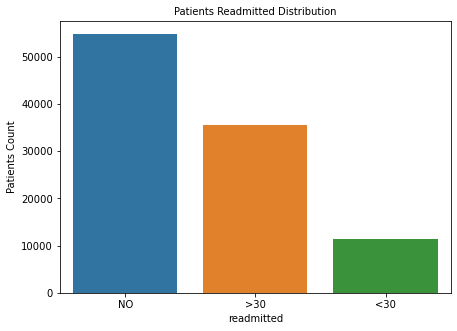

In [19]:
plotCharts(df, "readmitted")

We want to predict the patients who were re-admitted, hence we just need two classes '0' for No and '1' for Yes, hence we will merge '<30' and '>30' into one class which is '1'

In [20]:
df.readmitted = df.readmitted.replace({"NO":0,
                                       ">30":1,
                                       "<30":1})

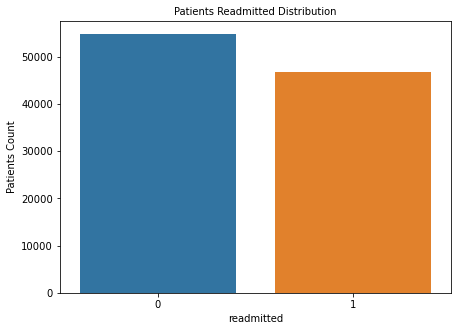

In [21]:
plotCharts(df, "readmitted")

### Race

In [22]:
df["race"].isnull().sum()

2273

#### Filling Null data with mode:
As we can see, there are null values present in the column 'race', so we will impute those values for by using mode

In [23]:
df['race'].fillna(df['race'].mode()[0], inplace=True)

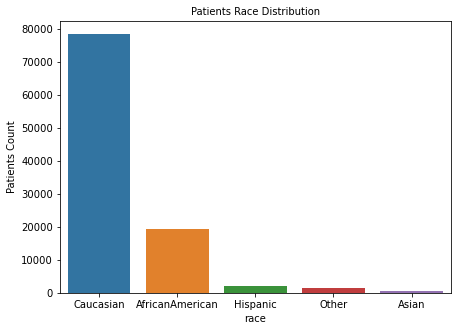

In [24]:
plotCharts(df, "race", "Cat")

Since 'Hispanic race' and 'Asian race' has very less number of values, we will combine them with 'Other'

In [25]:
df.loc[df["race"] == "Hispanic", "race"] = "Other"
    
df.loc[df["race"] == "Asian", "race"] = "Other"

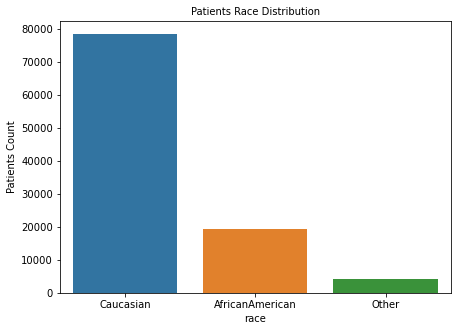

In [26]:
plotCharts(df, "race")

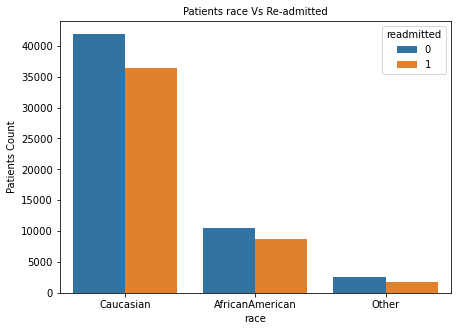

In [27]:
plotColvsReadmitted(df, "race", "readmitted", "Cat")

The number of patients that were being re-admitted and not re-admitted had the almost same trend with Caucasian having the highest patient count.

###  gender

In [28]:
df["gender"].isnull().sum()

0

There were no null values for this column

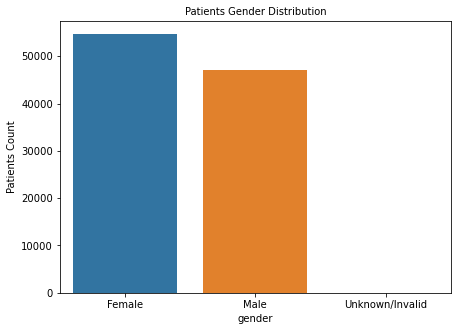

In [29]:
plotCharts(df, "gender")

In [30]:
df["gender"].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

The 'Unknown/Invalid'had 3 patients, which is very less as compared to the other categories, hence, we will drop those records. 

In [31]:
df = df[df['gender']!='Unknown/Invalid']

Now, we will make the column binary with 'Female'=0 and 'Male'=1 

In [32]:
df.gender = df.gender.replace({"Female":0, "Male":1})
df["gender"].value_counts()

0    54708
1    47055
Name: gender, dtype: int64

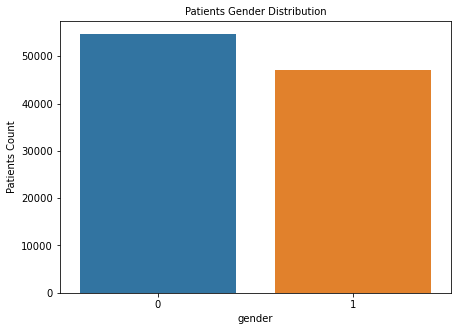

In [33]:
plotCharts(df, "gender")

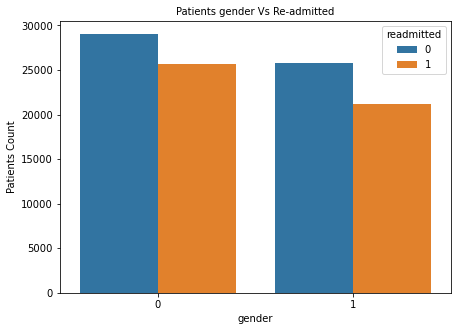

In [34]:
plotColvsReadmitted(df, "gender", "readmitted", "Cat")

There were more female patients who were readmitted as compared to their male counterparts.

## Age

In [35]:
df["age"].value_counts()

[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

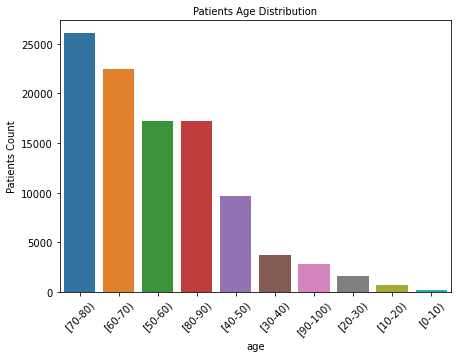

In [36]:
plotCharts(df, "age")

For the age brackets, we will take the average of the lower value and the upper value in the bin. 

In [37]:
df['age'] = df['age'].map({'[0-10)':5,
                           '[10-20)':15, 
                           '[20-30)':25,
                           '[30-40)':35,
                           '[40-50)':45,
                           '[50-60)':55,
                           '[60-70)':65,
                           '[70-80)':75,
                           '[80-90)':85,
                           '[90-100)':95})

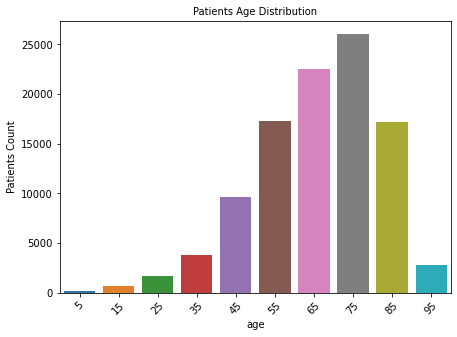

In [38]:
plotCharts(df, "age")

The dataset contained a large number of records from elderly patients, indicating that they were the majority in the dataset.

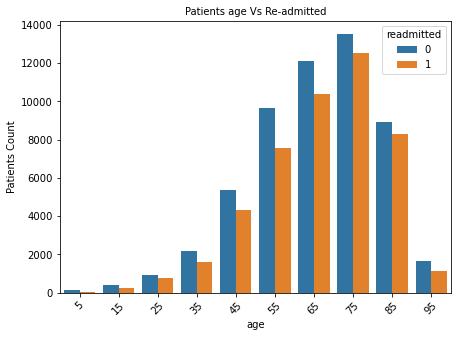

In [39]:
plotColvsReadmitted(df, "age", "readmitted", "Cat")

The distribution between the number of patients who were readmitted and those who were not readmitted is same.

### admission_type_id

#### Description of admission_type_id :

1. Emergency
2. Urgent
3. Elective
4. Newborn
5. Not Available
6. NULL
7. Trauma Center
8. Not Mapped

In [40]:
df['admission_type_id'].value_counts()

1    53988
3    18868
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

Emergency and Urgent care can be grouped into single group as Emergency. Not Available, Not Mapped, Null can be mapped as Null. And since, Trauma Center and Newborn has less than 0.05% of data, we can remove them

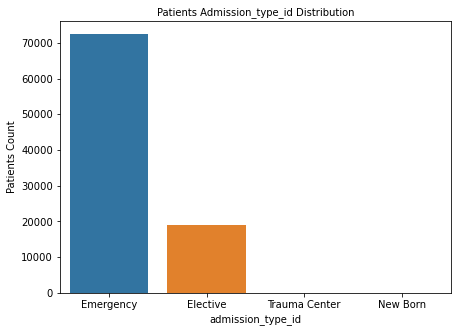

In [41]:
# Grouping the values

df.admission_type_id = df.admission_type_id.replace({1.0:"Emergency",
                                                              2.0:"Emergency",
                                                              3.0:"Elective",
                                                              4.0:"New Born",
                                                              5.0:np.nan,
                                                              6.0:np.nan,
                                                              7.0:"Trauma Center",
                                                              8.0:np.nan})

plotCharts(df, "admission_type_id")

Since data is less for Trauma Centre and New Born, we can remove both

In [42]:
df = df[df['admission_type_id']!='Trauma Center']
df = df[df['admission_type_id']!='New Born']

In [43]:
df["admission_type_id"].isnull().sum()

10396

There were 10396 Observations with Null Values, hence, using mode to impute values in place of Null

In [44]:
df['admission_type_id'].fillna(df['admission_type_id'].mode()[0], inplace=True)

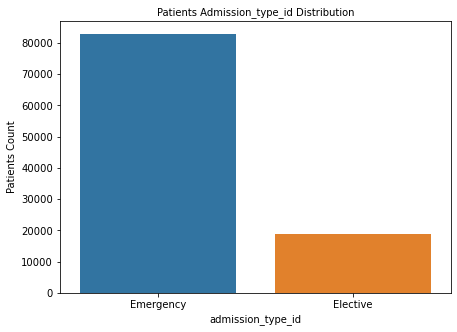

In [45]:
plotCharts(df, "admission_type_id")

Transforming the column into binary by replacing 'Elective' as 1 and 'Elective' as 0

In [46]:
df.admission_type_id = df.admission_type_id.replace({"Elective":0,
                                                              "Emergency":1})
df["admission_type_id"].value_counts()

1    82864
0    18868
Name: admission_type_id, dtype: int64

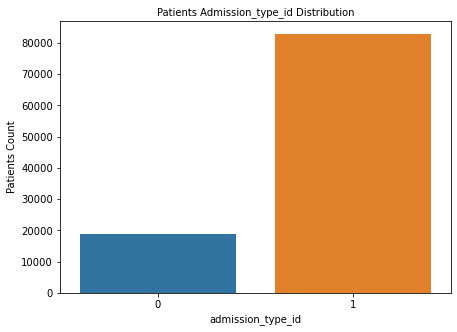

In [47]:
plotCharts(df, "admission_type_id")

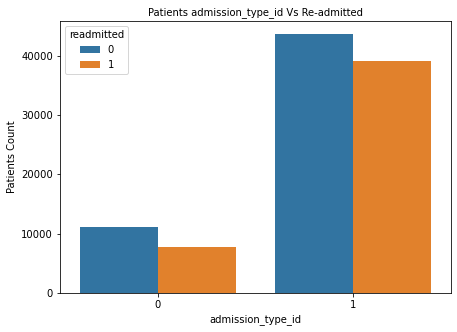

In [48]:
plotColvsReadmitted(df, "admission_type_id", "readmitted", "Cat")

The distribution between the number of patients who were readmitted and those who were not readmitted is same.

### Discharge_disposition_id Description

1. Discharged to home
2. Discharged/transferred to another short term hospital
3. Discharged/transferred to SNF
4. Discharged/transferred to ICF
5. Discharged/transferred to another type of inpatient care institution
6. Discharged/transferred to home with home health service
7. Left AMA
8. Discharged/transferred to home under care of Home IV provider
9. Admitted as an inpatient to this hospital
10. Neonate discharged to another hospital for neonatal aftercare
11. Expired
12. Still patient or expected to return for outpatient services
13. Hospice / home
14. Hospice / medical facility
15. Discharged/transferred within this institution to Medicare approved swing bed
16. Discharged/transferred/referred another institution for outpatient services
17. Discharged/transferred/referred to this institution for outpatient services
18. NULL
19. Expired at home. Medicaid only, hospice.
20. Expired in a medical facility. Medicaid only, hospice.
21. Expired, place unknown. Medicaid only, hospice.
22. Discharged/transferred to another rehab fac including rehab units of a hospital .
23. Discharged/transferred to a long term care hospital.
24. Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25. Not Mapped
26. Unknown/Invalid
30. Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
27. Discharged/transferred to a federal health care facility.
28. Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29. Discharged/transferred to a Critical Access Hospital (CAH)

In [49]:
df['discharge_disposition_id'].value_counts()

1     60221
3     13948
6     12895
18     3691
2      2127
22     1989
11     1639
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

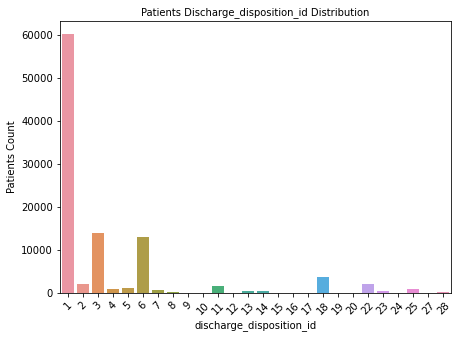

In [50]:
plotCharts(df, "discharge_disposition_id")

It can be noticed that there were too many data points. To solve this problem, we used the following rules:

- If a patient was sent home after being discharged, they can be grouped as "Home". 
- If they were sent elsewhere, they can be grouped as "Another Facility". 
- If the patient is expired or Hospice, they can be grouped as "Expired".
- Some specific values like 25, 26, and 18 can be mapped as as null values.

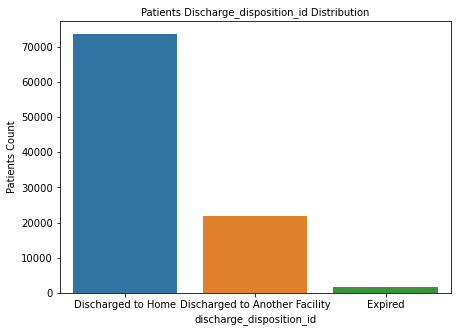

In [51]:
# Mapping the rules mentioned above

df.discharge_disposition_id = df.discharge_disposition_id.replace(
                    {1.0:"Discharged to Home",
                    6.0:"Discharged to Home",
                    8.0:"Discharged to Home",
                    13.0:"Discharged to Home",
                    19.0:"Expired",
                    18.0:np.nan,25.0:np.nan,26.0:np.nan,
                    2.0:"Discharged to Another Facility"
                    ,3.0:"Discharged to Another Facility"
                    ,4.0:"Discharged to Another Facility",
                    5.0:"Discharged to Another Facility"
                    ,7.0:"Discharged to Another Facility"
                    ,9:"Discharged to Another Facility",
                    10:"Discharged to Another Facility"
                    ,11:"Expired"
                    ,12:"Discharged to Another Facility",
                    14:"Discharged to Another Facility"
                    ,15:"Discharged to Another Facility"
                    ,16:"Discharged to Another Facility",
                    17:"Discharged to Another Facility"
                    ,20:"Expired"
                    ,21:"Expired",
                    22:"Discharged to Another Facility"
                    ,23:"Discharged to Another Facility"
                    ,24:"Discharged to Another Facility",
                    27:"Discharged to Another Facility"
                    ,28:"Discharged to Another Facility"
                    ,29:"Discharged to Another Facility"
                    ,30:"Discharged to Another Facility"})

plotCharts(df, "discharge_disposition_id")

We can exclude the patient data for those who have passed away because they will never be readmitted. Therefore, we can remove the data of patients who have been marked as "Expired" from our dataset. 

In [52]:
df = df[df['discharge_disposition_id']!='Expired']

In [53]:
df["discharge_disposition_id"].isnull().sum()

4680

There are 10396 Observations with Null Values, hence, using mode to impute values in place of Null

In [54]:
df['discharge_disposition_id'].fillna(df['discharge_disposition_id'].mode()[0], inplace=True)

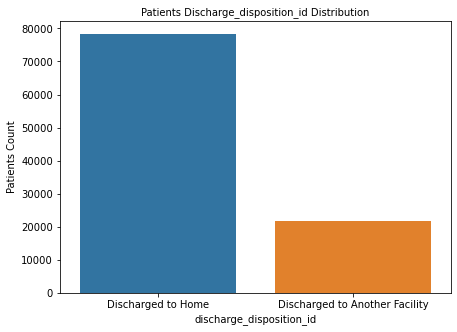

In [55]:
plotCharts(df, "discharge_disposition_id")

Transforming the column into binary by replacing 'Discharged to Another Facility' as 1 and 'Discharged to Home' as 0

In [56]:
df.discharge_disposition_id = df.discharge_disposition_id.replace({"Discharged to Home":0,
                                                              "Discharged to Another Facility":1})
df["discharge_disposition_id"].value_counts()

0    78303
1    21780
Name: discharge_disposition_id, dtype: int64

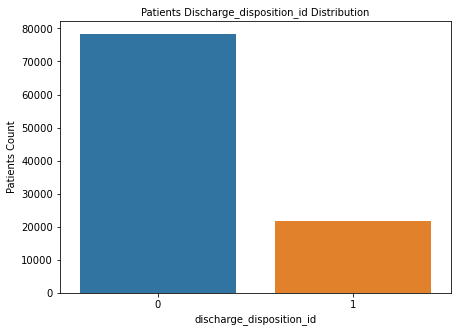

In [57]:
plotCharts(df, "discharge_disposition_id")

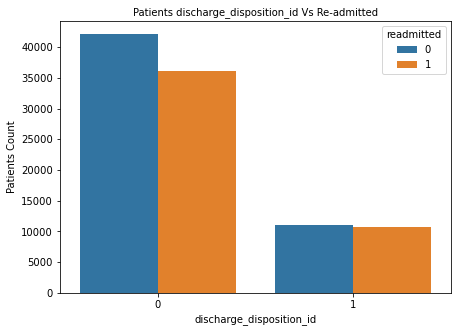

In [58]:
plotColvsReadmitted(df, "discharge_disposition_id", "readmitted", "Cat")

The distribution between the number of patients who were readmitted and those who were not readmitted is same.

### admission_source_id	description
1. Physician Referral
2. Clinic Referral
3. HMO Referral
4. Transfer from a hospital
5. Transfer from a Skilled Nursing Facility (SNF)
6. Transfer from another health care facility
7. Emergency Room
8. Court/Law Enforcement
9. Not Available
10. Transfer from critial access hospital
11. Normal Delivery
12. Premature Delivery
13. Sick Baby
14. Extramural Birth
15. Not Available
17. NULL
18. Transfer From Another Home Health Agency
19. Readmission to Same Home Health Agency
20. Not Mapped
21. Unknown/Invalid
22. Transfer from hospital inpt/same fac reslt in a sep claim
23. Born inside this hospital
24. Born outside this hospital
25. Transfer from Ambulatory Surgery Center
26. Transfer from Hospice

In [59]:
df['admission_source_id'].value_counts()

7     56341
1     29319
17     6645
4      3127
6      2244
2      1083
5       814
3       185
20      159
9       125
8        15
22       12
10        8
11        2
25        2
14        1
13        1
Name: admission_source_id, dtype: int64

Since, there are many values which can be mapped into one category. We have combined them as following:

- Referral: Physician Referral, Clinic Referral, HMO Referral
- Transfer: Transfer from a hospital, Transfer from a Skilled Nursing Facility (SNF), Transfer from another health care facility, Court/Law Enforcement, Transfer from critial access hospital, Normal Delivery, Premature Delivery, Sick Baby, Extramural Birth, Transfer from hospital inpt/same fac reslt in a sep claim, Born inside this hospital, Born outside this hospital, Transfer from Ambulatory Surgery Center, Transfer from Hospice, Transfer From Another Home Health Agency, Readmission to Same Home Health Agency
- Emergency: Emergency Room
- Null: NULL, Not Available, Not Mapped, Unknown/Invalid


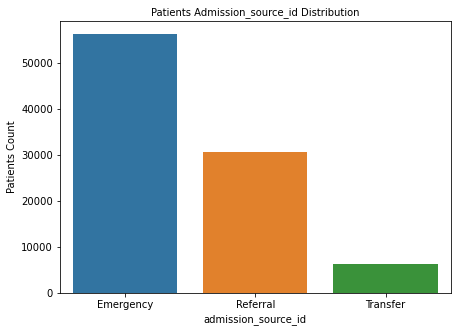

In [60]:
# Mapping the values as mentioned above

df.admission_source_id = df.admission_source_id.replace(
                    {1:"Referral",
                     2:"Referral",
                     3:"Referral",
                      4:"Transfer",
                     5:"Transfer",
                     6:"Transfer",
                     10:"Transfer",
                     22:"Transfer",
                     25:"Transfer",
                      9:np.nan,
                     8:"Transfer",
                     14:"Transfer",
                     13:"Transfer",
                     11:"Transfer",
                      15:np.nan,
                     17:np.nan,
                     20:np.nan,
                     21:np.nan,
                      7:"Emergency"})

plotCharts(df, "admission_source_id")

In [61]:
df["admission_source_id"].isnull().sum()

6929

In [62]:
df['admission_source_id'].fillna(df['admission_source_id'].mode()[0], inplace=True)

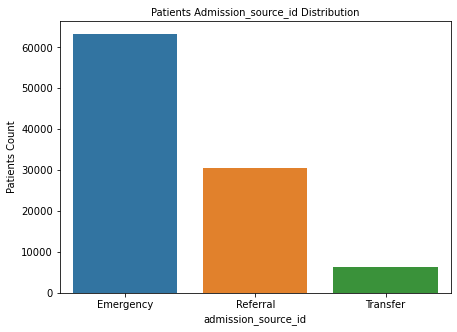

In [63]:
plotCharts(df, "admission_source_id")

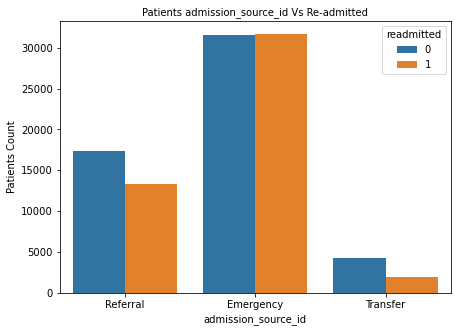

In [64]:
plotColvsReadmitted(df, "admission_source_id", "readmitted", "Cat")

The distribution between the number of patients who were readmitted and those who were not readmitted is same.

#### ICD-9 codes


001-139    INFECTIOUS AND PARASITIC DISEASES\
140-239    NEOPLASMS\
240-279    ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS\
280-289    DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS\
290-319    MENTAL, BEHAVIORAL AND NEURODEVELOPMENTAL DISORDERS\
320-389    DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS\
390-459    DISEASES OF THE CIRCULATORY SYSTEM\
460-519    DISEASES OF THE RESPIRATORY SYSTEM\
520-579    DISEASES OF THE DIGESTIVE SYSTEM\
580-629    DISEASES OF THE GENITOURINARY SYSTEM\
630-679    COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM\
680-709    DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE\
710-739    DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE\
740-759    CONGENITAL ANOMALIES\
760-779    CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD\
780-799    SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS\
800-999    INJURY AND POISONING\
E000-E999    SUPPLEMENTARY CLASSIFICATION OF EXTERNAL CAUSES OF INJURY AND POISONING\

reference - https://www.aapc.com/codes/icd9-codes-range/

There are around 750+ unique ICD 9 codes in each of the diag columns. Based on the ICD-9 groups we will group the codes

In [65]:
print("diag_1: ",df['diag_1'].nunique())
print("diag_2: ",df['diag_2'].nunique())
print("diag_3: ",df['diag_3'].nunique())

diag_1:  714
diag_2:  746
diag_3:  787


In [66]:
diagnosis_cols = ['diag_1','diag_2','diag_3']

We will impute the nan with diabetes as the dataset is primarily on diabetes

In [67]:
def transformCategory(value):
    if value==250 or value is np.nan:
        return 'Diabetes'
    elif value>=390 and value<=459 or value==785:
        return 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        return 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        return 'Digestive'
    elif value>=800 and value<=999:
        return 'Injury'          
    elif value>=710 and value<=739:
        return 'Musculoskeletal'   
    elif value>=580 and value<=629 or value==788:
        return 'Genitourinary'
    elif value>=140 and value<=239 :
        return 'Neoplasms'
#     elif value is np.nan:
#         return np.nan
    else :
        return 'Other'

In [68]:
for col in diagnosis_cols:
    df.loc[(df[col].str.contains("V")) | (df[col].str.contains("E")), col] = -1
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(transformCategory)

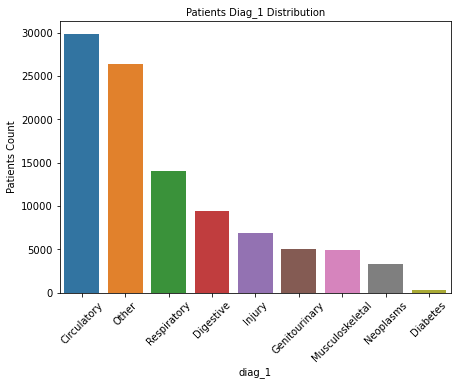

In [69]:
plotCharts(df, "diag_1")

Majority of the patients in the dataset were diagnosed with Circulatory i.e. diabetes

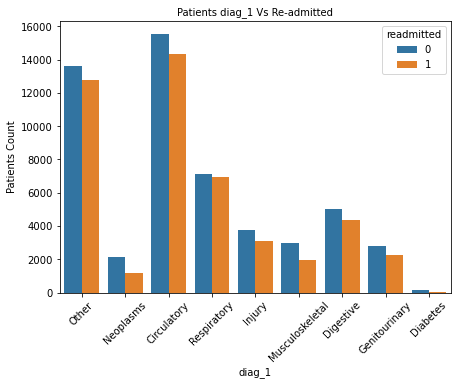

In [70]:
plotColvsReadmitted(df, "diag_1", "readmitted", "Cat")

The distribution between the number of patients who were readmitted and those who were not readmitted is same.

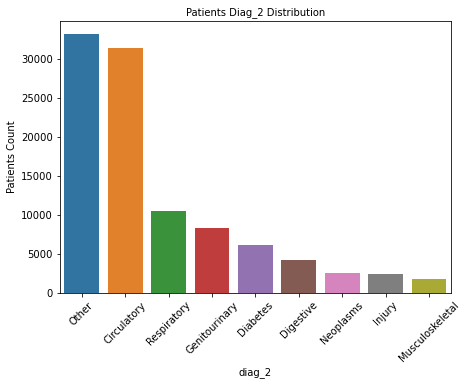

In [71]:
plotCharts(df, "diag_2")

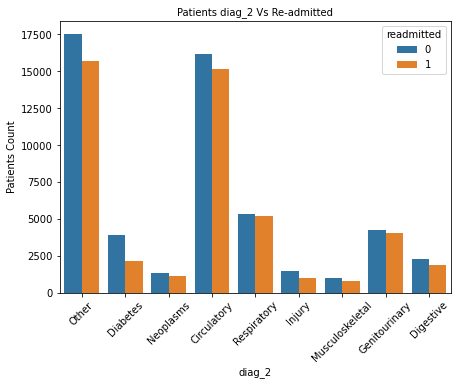

In [72]:
plotColvsReadmitted(df, "diag_2", "readmitted", "Cat")

The distribution between the number of patients who were readmitted and those who were not readmitted is same.

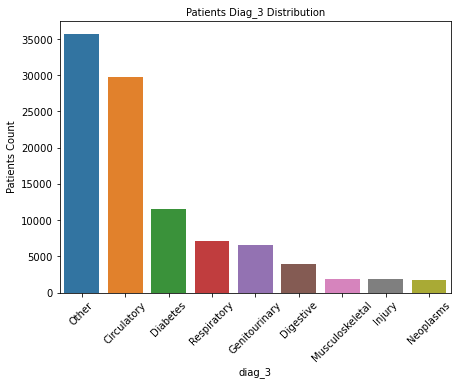

In [73]:
plotCharts(df, "diag_3")

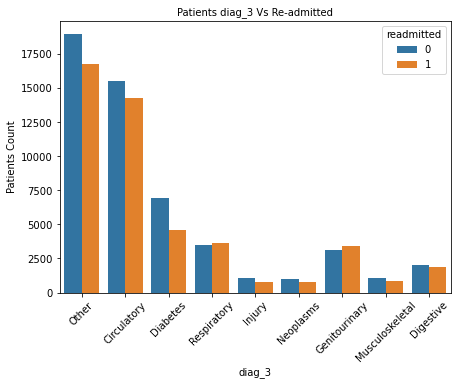

In [74]:
plotColvsReadmitted(df, "diag_3", "readmitted", "Cat")

The distribution between the number of patients who were readmitted and those who were not readmitted is same.

#### max_glu_serum

In [75]:
df["max_glu_serum"].value_counts()

None    94859
Norm     2573
>200     1440
>300     1211
Name: max_glu_serum, dtype: int64

Replacing the values according to range of the results for glucose serum tests. Grouping  ">200" and ">300" to 1, "Norm" to 0, "None" to -99

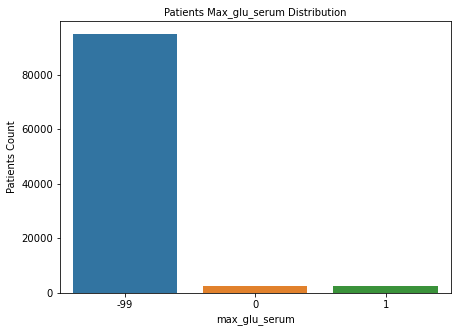

In [76]:
df["max_glu_serum"] = df["max_glu_serum"].replace({">200":1,
                                                        ">300":1,
                                                        "Norm":0,
                                                        "None":-99})

plotCharts(df, "max_glu_serum")

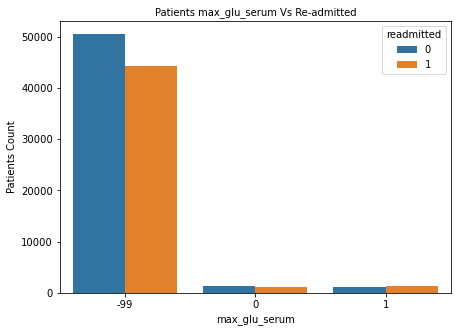

In [77]:
plotColvsReadmitted(df, "max_glu_serum", "readmitted", "Cat")

#### A1Cresult

In [78]:
df["A1Cresult"].value_counts()

None    83213
>8       8151
Norm     4937
>7       3782
Name: A1Cresult, dtype: int64

Replacing the values according to the range of result for the glucose serum tests. Grouping  ">7" and ">8" to 1, "Norm" to 0, "None" to -99

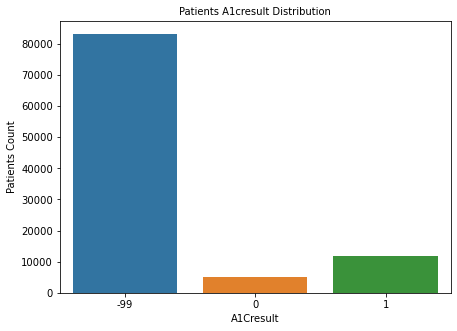

In [79]:
df["A1Cresult"] = df["A1Cresult"].replace({">8":1,
                                                        ">7":1,
                                                        "Norm":0,
                                                        "None":-99})

plotCharts(df, "A1Cresult")


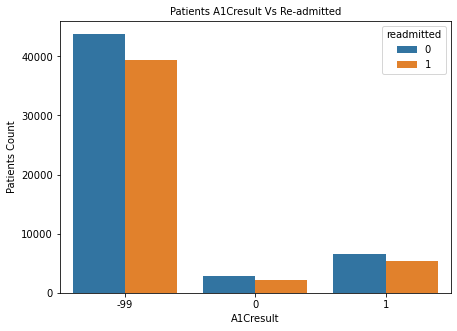

In [80]:
plotColvsReadmitted(df, "A1Cresult", "readmitted", "Cat")

#### time_in_hospital

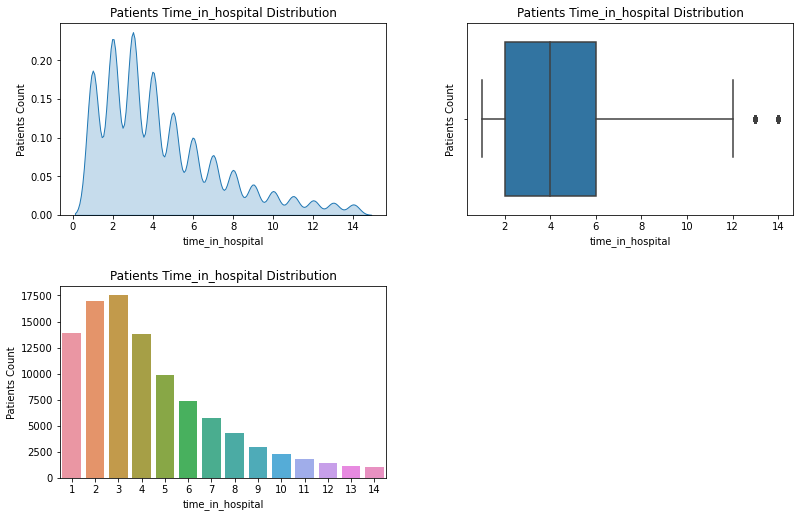

In [81]:
plotCharts(df, "time_in_hospital","Num")

There are some outliers present in the column, hence we will remove those using our defined funtion.

In [82]:
### removing outliers

df = remove_outliers(df, "time_in_hospital", 2.5)

Working on column: time_in_hospital


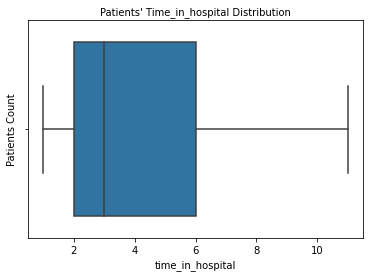

In [83]:
plotOutliers(df,"time_in_hospital")

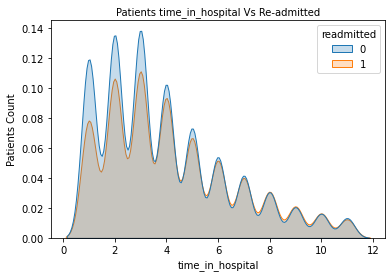

In [84]:
plotColvsReadmitted(df, "time_in_hospital", "readmitted", "Num")

The probability density between the number of patients who were readmitted and those who were not readmitted is same.

#### num_lab_procedures

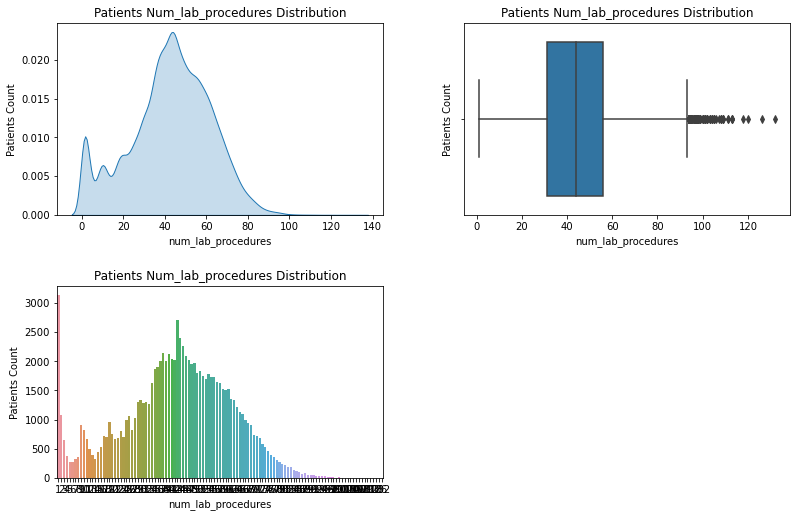

In [85]:
plotCharts(df,"num_lab_procedures","Num")

There are some outliers present in the column, hence we will remove those using our defined funtion.

In [86]:
# removing outliers

df = remove_outliers(df, "num_lab_procedures", 2.5)

Working on column: num_lab_procedures


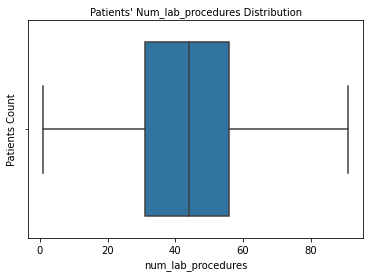

In [87]:
plotOutliers(df,"num_lab_procedures")

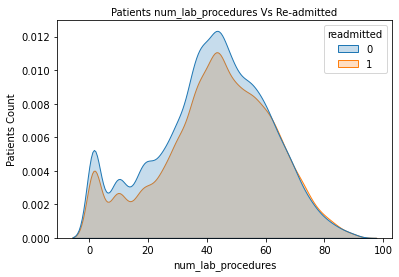

In [88]:
plotColvsReadmitted(df, "num_lab_procedures", "readmitted", "Num")

The probability density between the number of patients who were readmitted and those who were not readmitted is same.

#### num_procedures

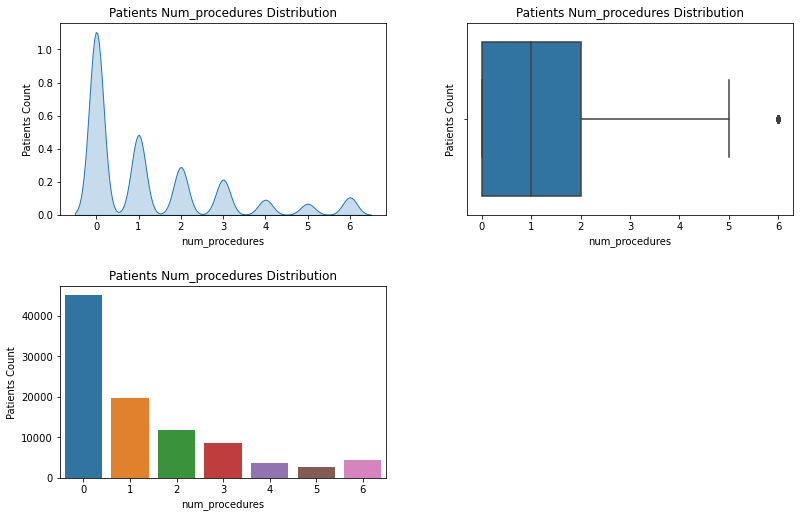

In [89]:
plotCharts(df,"num_procedures","Num")

In [90]:
# removing outliers
df = remove_outliers(df, "num_procedures", 2.5)

Working on column: num_procedures


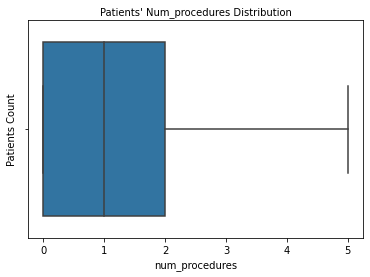

In [91]:
plotOutliers(df,"num_procedures")

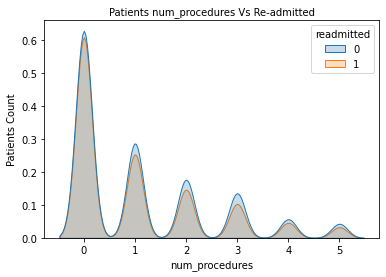

In [92]:
plotColvsReadmitted(df, "num_procedures", "readmitted", "Num")

The probability density between the number of patients who were readmitted and those who were not readmitted is same.

#### num_medications

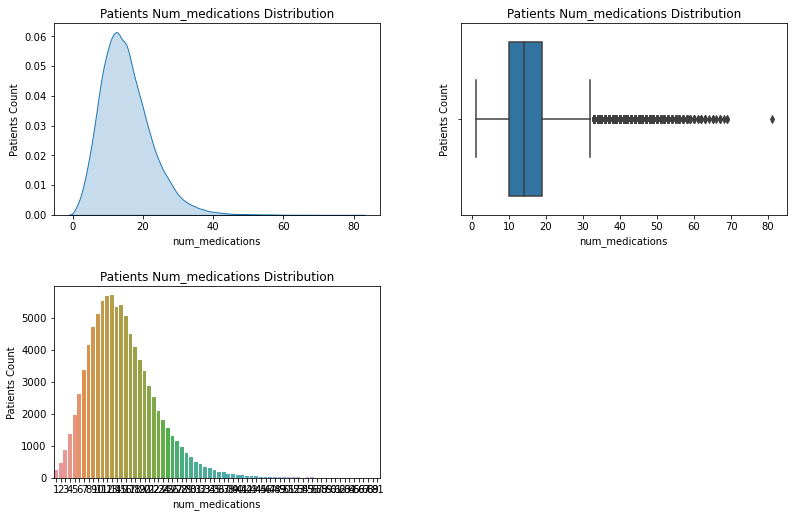

In [93]:
plotCharts(df,"num_medications","Num")

There are some outliers present in the column, hence we will remove those using our defined funtion.

In [94]:
# removing outliers

df = remove_outliers(df, "num_medications", 2.5)

Working on column: num_medications


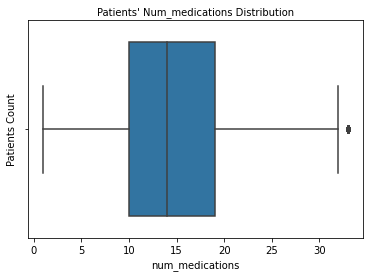

In [95]:
plotOutliers(df,"num_medications")

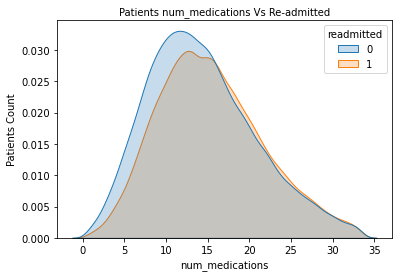

In [96]:
plotColvsReadmitted(df, "num_medications", "readmitted", "Num")

The probability density between the number of patients who were readmitted and those who were not readmitted is same.

#### number_outpatient

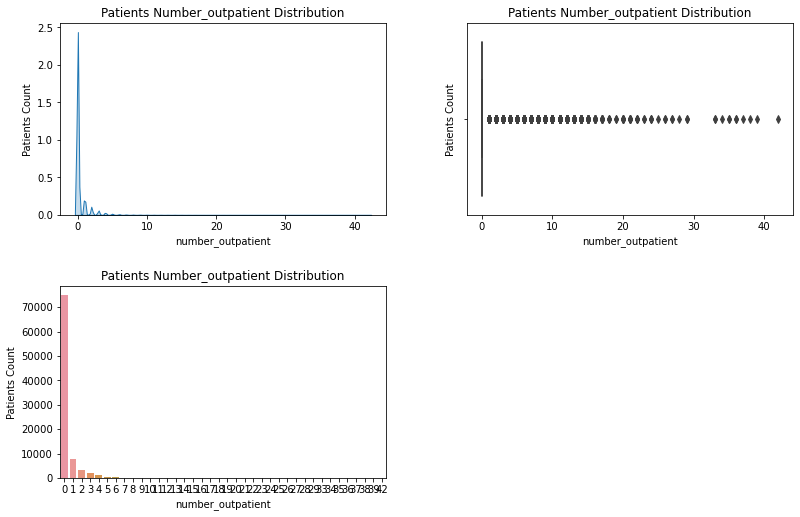

In [97]:
plotCharts(df,"number_outpatient","Num")

From the Boxplot, we can see that there are some outliers present in the column, we will have to treat those.

Also, the distribution of outpatient visits is highly skewed, making it difficult to understand any clear trend. To gain a better understanding, we need to examine the data in more detail.

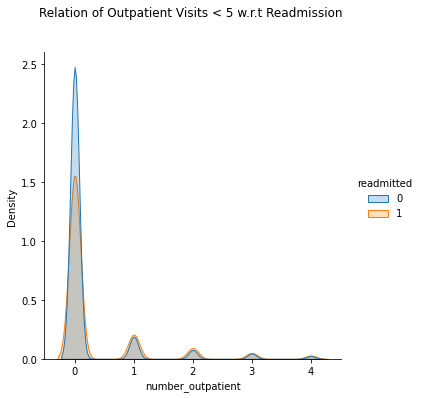

In [102]:
sns.displot(df.loc[df['number_outpatient']< 5], x="number_outpatient", hue= 'readmitted', kind ='kde', fill= True)
plt.title('Relation of Outpatient Visits < 5 w.r.t Readmission \n\n', size = 12)
plt.show()

Upon examining outpatient visits less than or equal to 5, we observed that patients were typically not readmitted

In [109]:
# removing outliers

df = remove_outliers(df, "number_outpatient", 2.5)


Working on column: number_outpatient


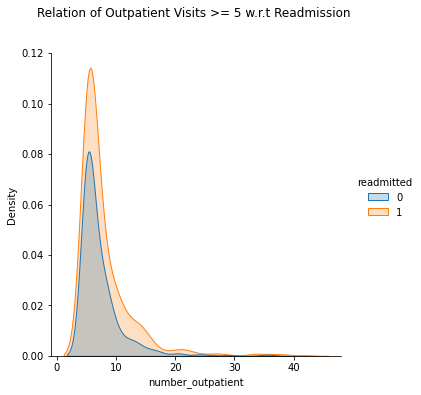

In [99]:
sns.displot(df.loc[df['number_outpatient']>=5], x="number_outpatient", hue= 'readmitted', kind ='kde', fill= True)
plt.title('Relation of Outpatient Visits >= 5 w.r.t Readmission \n\n', size = 12)
plt.show()

When we looked at outpatient visits greater than or equal to 5, we found that there were more cases of readmission than those who were not readmitted.

We noticed the outliers before, using our defined function to remove those.

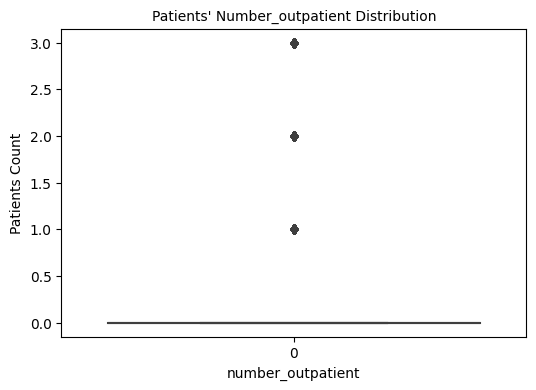

In [110]:
plotOutliers(df,"number_outpatient")

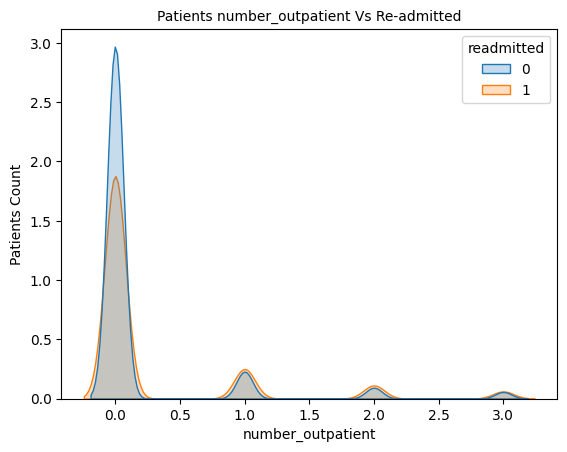

In [111]:
plotColvsReadmitted(df, "number_outpatient", "readmitted", "Num")

The probability density between the number of patients who were readmitted and those who were not readmitted is same.

#### number_emergency

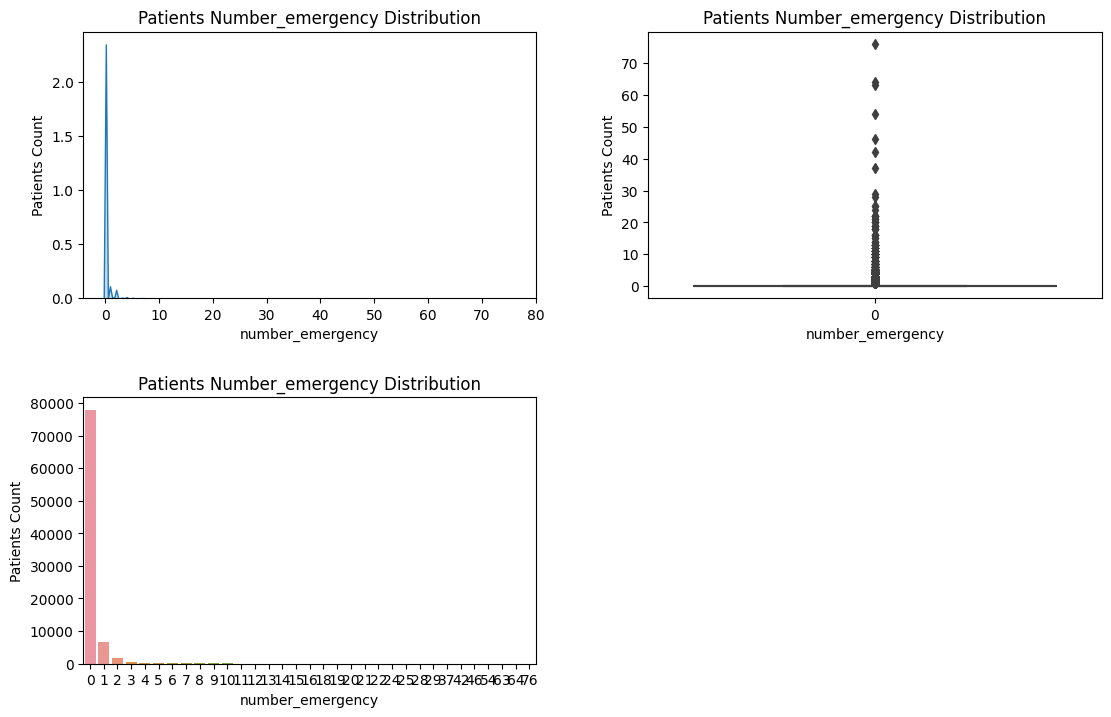

In [112]:
plotCharts(df,"number_emergency","Num")

From the boxplot, we can see that there are some outliers present in the column, we will have to treat those before moving forward.

Also, the distribution of Emergency Visits is highly skewed, with most patients having zero visits. Therefore, we need to slice and analyze the data to understand the trend in detail.

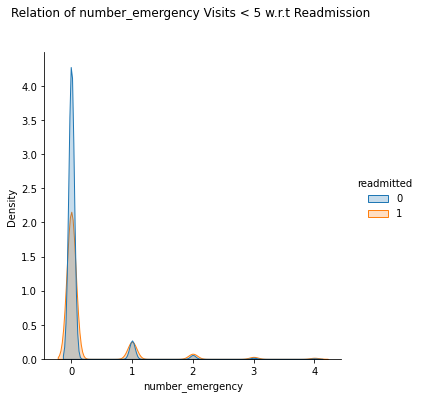

In [104]:
sns.displot(df.loc[df['number_emergency']< 5], x="number_emergency", hue= 'readmitted', kind ='kde', fill= True)
plt.title('Relation of number_emergency Visits < 5 w.r.t Readmission \n\n', size = 12)
plt.show()

When there are no emergency visits the number of Not Readmitted is higher than the number of Readmitted Patients.

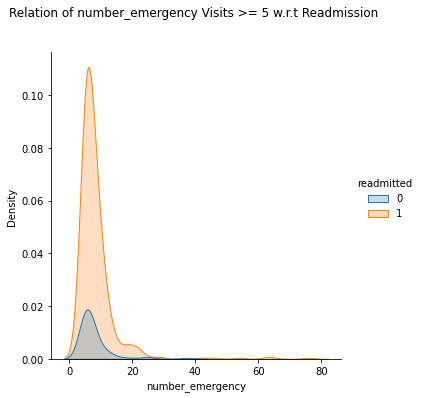

In [105]:
sns.displot(df.loc[df['number_emergency'] >= 5], x="number_emergency", hue= 'readmitted', kind ='kde', fill= True)
plt.title('Relation of number_emergency Visits >= 5 w.r.t Readmission \n\n', size = 12)
plt.show()

The number of emergency visits approaches 10, patients become more likely to be readmitted to the hospital.

The column had some outliers, hence we will remove those using our defined funtion.

In [113]:
# removing outliers

df = remove_outliers(df, "number_emergency", 2.5)

Working on column: number_emergency


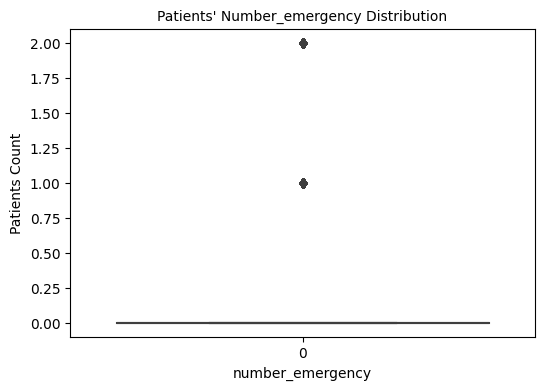

In [114]:
plotOutliers(df,"number_emergency")

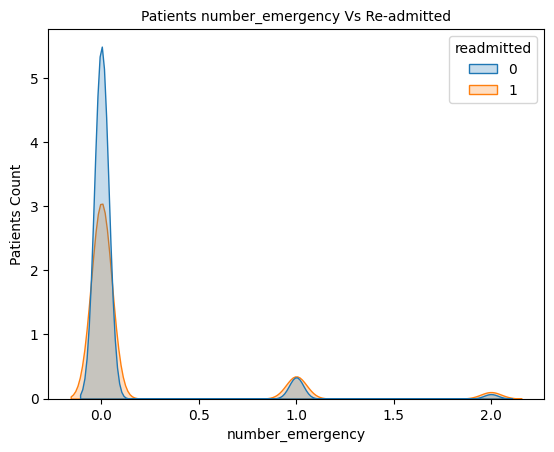

In [115]:
plotColvsReadmitted(df, "number_emergency", "readmitted", "Num")

The probability density between the number of patients who were readmitted and those who were not readmitted is same.

#### number_diagnoses

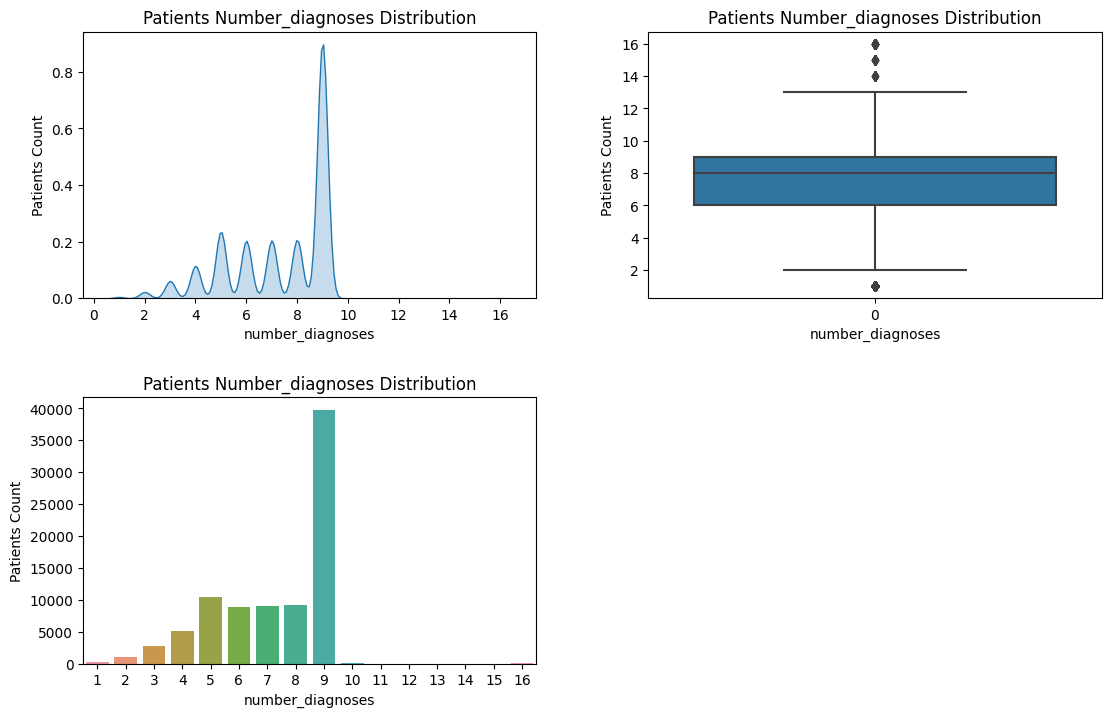

In [116]:
plotCharts(df,"number_diagnoses","Num")

There are some outliers present in the column, hence we will remove those using our defined funtion.

In [117]:
# removing outliers

df = remove_outliers(df, "number_diagnoses", 2.5)

Working on column: number_diagnoses


In [118]:
# Checking Null values
df["number_diagnoses"].isnull().sum()

0

In [119]:
df.reset_index(inplace = True)
df.drop("index",axis = 1,inplace=True)

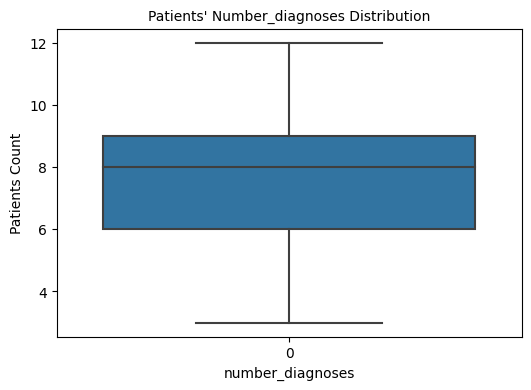

In [120]:
plotOutliers(df,"number_diagnoses")

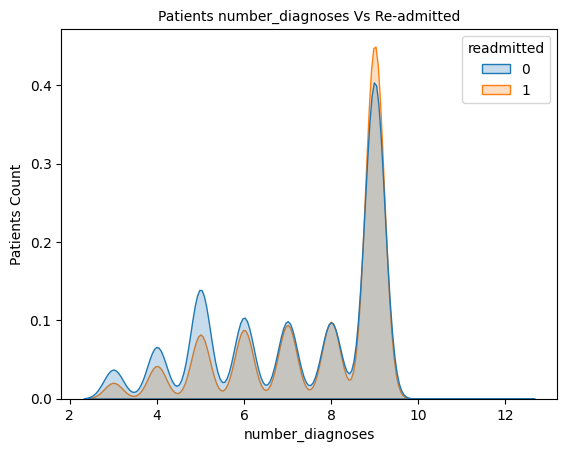

In [121]:
plotColvsReadmitted(df, "number_diagnoses", "readmitted", "Num")

The probability density between the number of patients who were readmitted and those who were not readmitted is same.

#### Diabetes Medications:
 
 The rest of the column has diabetic medicines.
- metformin 
- repaglinide
- nateglinide
- chlorpropamide
- glimepiride
- acetohexamide
- glipizide
- glyburide
- tolbutamide
- pioglitazone
- rosiglitazone
- acarbose
- miglitol
- troglitazone
- tolazamide
- examide
- citoglipton
- insulin
- glyburide-metformin
- glipizide-metformin
- glimepiride-pioglitazone
- metformin-rosiglitazone
- metformin-pioglitazone
 
 This feature describes whether the drug was prescribed or if there was a change in thr dosage. We will group all these values into binary. Grouping "No" to 0 and "Steady", "Up", "Down", "Ch", "Yes" to 1.

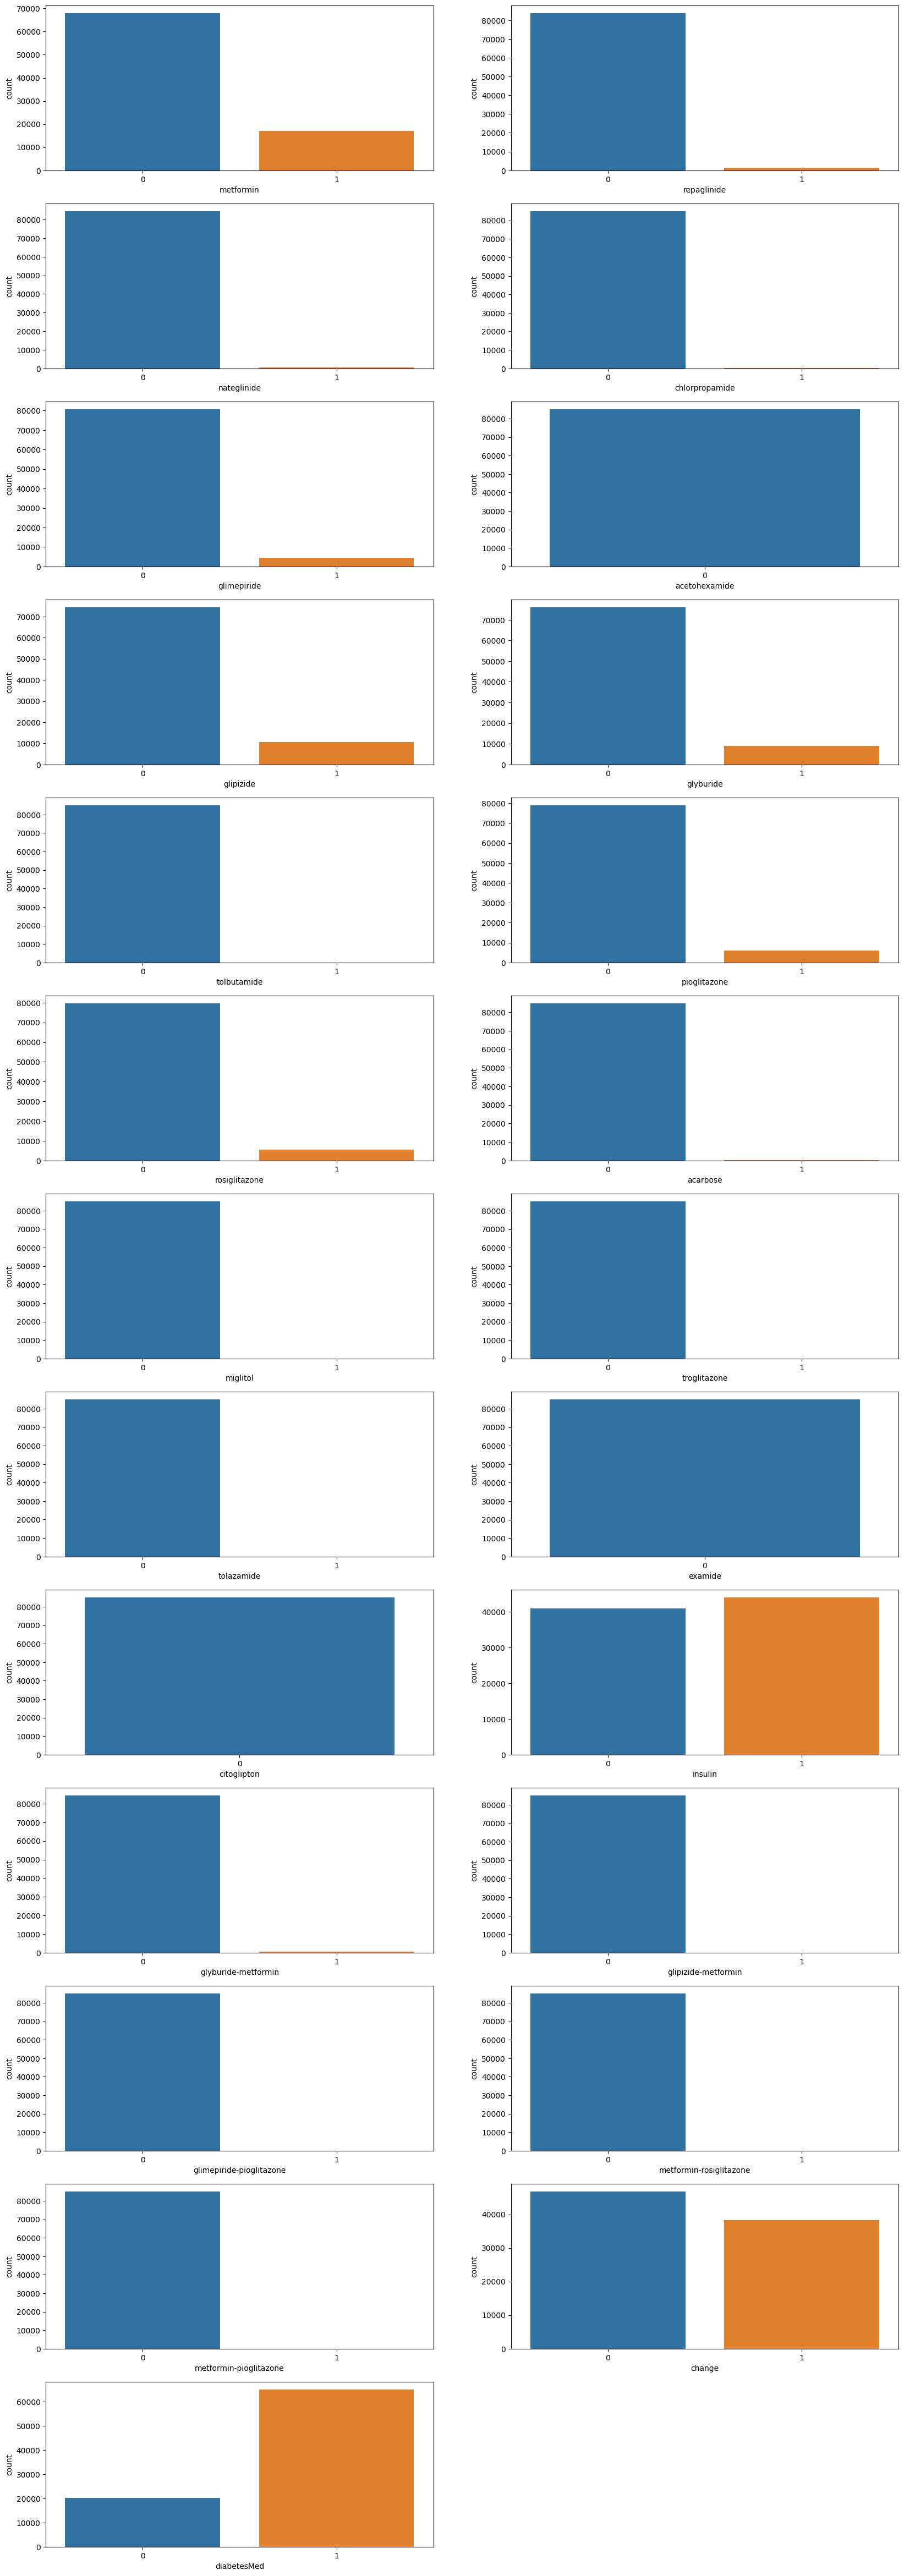

In [122]:
feature_med = ['metformin', 
               'repaglinide',
               'nateglinide',
               'chlorpropamide',
               'glimepiride',
               'acetohexamide',
               'glipizide',
               'glyburide',
               'tolbutamide',
               'pioglitazone',
               'rosiglitazone',
               'acarbose',
               'miglitol',
               'troglitazone',
               'tolazamide',
               'examide',
               'citoglipton',
               'insulin',
               'glyburide-metformin',
               'glipizide-metformin',
               'glimepiride-pioglitazone',
               'metformin-rosiglitazone',
               'metformin-pioglitazone',
               'change',
               'diabetesMed']

for x in df.columns:
    if x in feature_med:
        df[x]=df[x].replace({"No":0,
                             "Steady":1,
                             "Up":1,
                             "Down":1,
                             "Ch":1,
                             "Yes": 1})
        
fig=plt.figure(figsize=(20,60))
for col in enumerate(feature_med):
    plt.subplot(13,2,col[0]+1)
    sns.countplot( data = df, x = col[1], fill= True)

There are few diabetic medicines with less than 2% of data for prescribed. So we will be removing those columns

In [123]:
# dropping the above mentione dcolumns

df.drop(['repaglinide',
               'nateglinide',
               'chlorpropamide',
               'acetohexamide',
               'tolbutamide',
               'acarbose',
               'miglitol',
               'troglitazone',
               'tolazamide',
               'examide',
               'citoglipton',
               'glyburide-metformin',
               'glipizide-metformin',
               'glimepiride-pioglitazone',
               'metformin-rosiglitazone',
               'metformin-pioglitazone'], 
        axis=1, inplace=True)

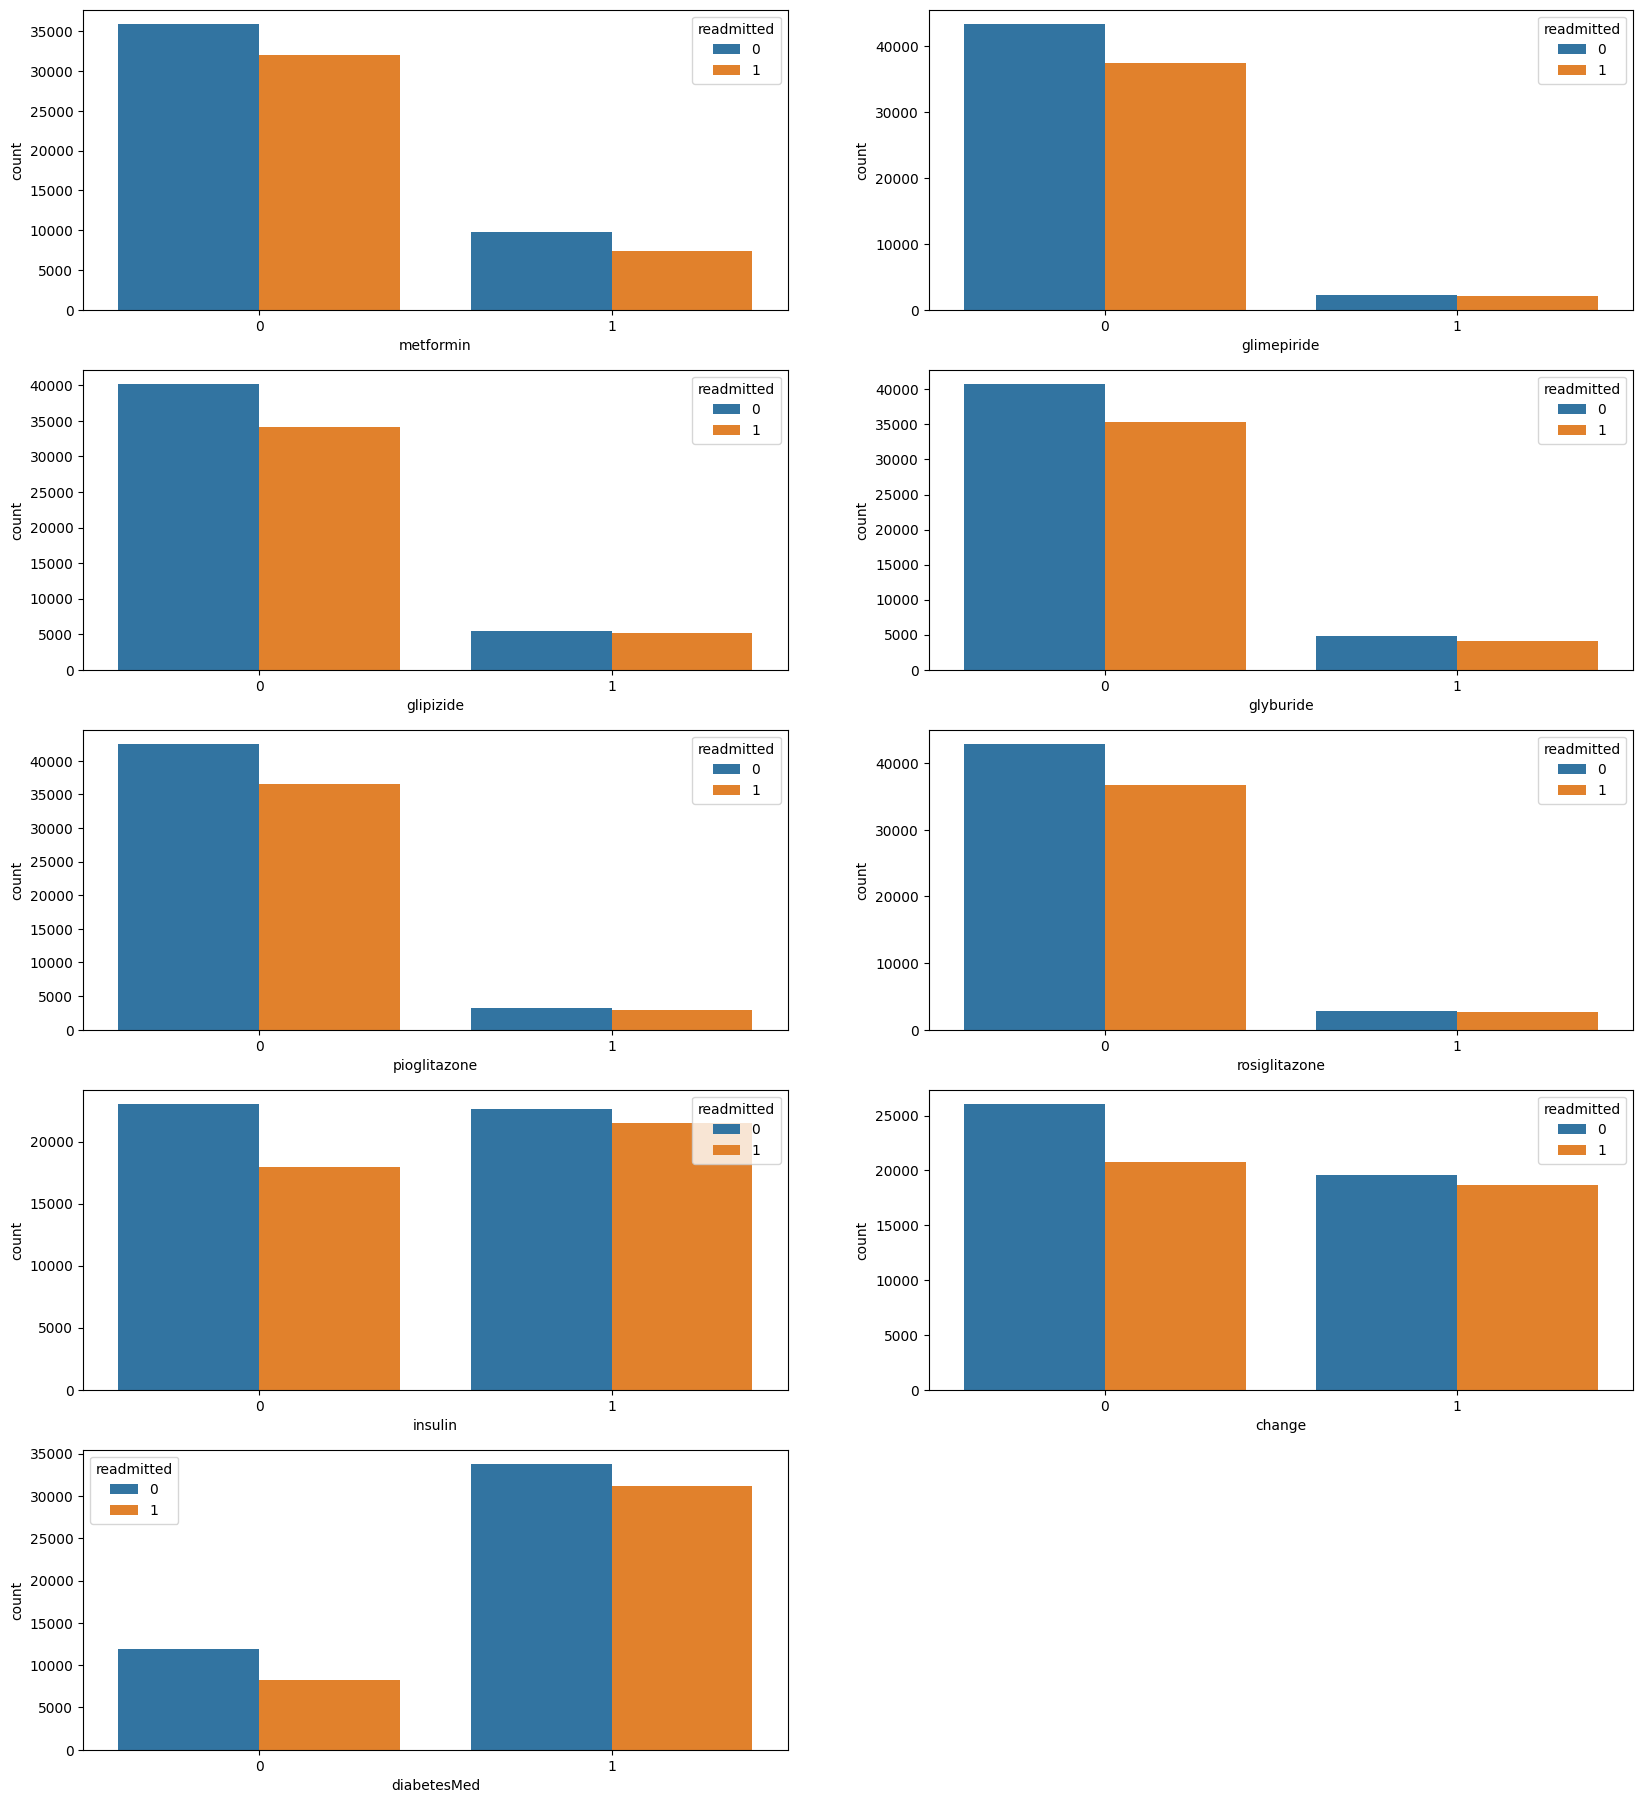

In [124]:
dataCols = ['metformin',
               'glimepiride',
               'glipizide',
               'glyburide',
               'pioglitazone',
               'rosiglitazone',
               'insulin',
               'change',
               'diabetesMed']

fig=plt.figure(figsize=(20,60))
for col in enumerate(dataCols):
    plt.subplot(13,2,col[0]+1)
    sns.countplot( data = df, x = col[1], hue = "readmitted", fill= True)

### Data Engineering

In [125]:
df["diag_1"].value_counts()

Circulatory        23730
Other              22470
Respiratory        12695
Digestive           8376
Injury              5999
Genitourinary       4537
Musculoskeletal     4299
Neoplasms           2746
Diabetes             188
Name: diag_1, dtype: int64

In [126]:
df["diag_2"].value_counts()

Other              28769
Circulatory        25922
Respiratory         9005
Genitourinary       7064
Diabetes            5141
Digestive           3617
Neoplasms           2145
Injury              1856
Musculoskeletal     1521
Name: diag_2, dtype: int64

In [127]:
df["diag_3"].value_counts()

Other              29991
Circulatory        25198
Diabetes           10369
Respiratory         5919
Genitourinary       5493
Digestive           3403
Musculoskeletal     1653
Neoplasms           1541
Injury              1473
Name: diag_3, dtype: int64

The columns diag_1, diag_2, diag_3 falls under the same categories, so dividing them into 9 different columns for each diagnosis. Assigining diag_1 to 3, diag_2 to 2, and diag_3 to 1

In [128]:
cols = ['Diabetes', 'Circulatory', 'Respiratory', 'Digestive', 'Injury', 'Musculoskeletal', 'Genitourinary',
       'Genitourinary', 'Neoplasms', 'Other']

for i in cols:
    df[i] = 0
    df.loc[df["diag_3"] == i, i] += 1
    df.loc[df["diag_2"] == i, i] += 2
    df.loc[df["diag_1"] == i, i] += 3

In [129]:
df.drop(['diag_1','diag_2','diag_3'], axis=1, inplace=True)

#### One-hot Encoding:

We performed encoding for race and admission_source_id. We splitted the Caucasian race and AfricanAmerican into two columns. We performed the same thing for Emergency and Referral in admission_source_id

#### race 

In [130]:
df["race_caucasian"] = 0
df.loc[df["race"]=="Caucasian", "race_caucasian"] = 1
df["race_africanAmerican"] = 0
df.loc[df["race"]=="AfricanAmerican", "race_africanAmerican"] = 1
df.drop(['race'], axis=1, inplace=True)

In [131]:
df[["race_caucasian","race_africanAmerican"]].head(5)

,race_caucasian,race_africanAmerican
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


#### admission_source_id

In [132]:
df["admission_Emergency"] = 0
df.loc[df["admission_source_id"]=="Emergency", "admission_Emergency"] = 1
df["admission_Referral"] = 0
df.loc[df["admission_source_id"]=="Referral", "admission_Referral"] = 1  

df.drop(['admission_source_id'], axis=1, inplace=True)

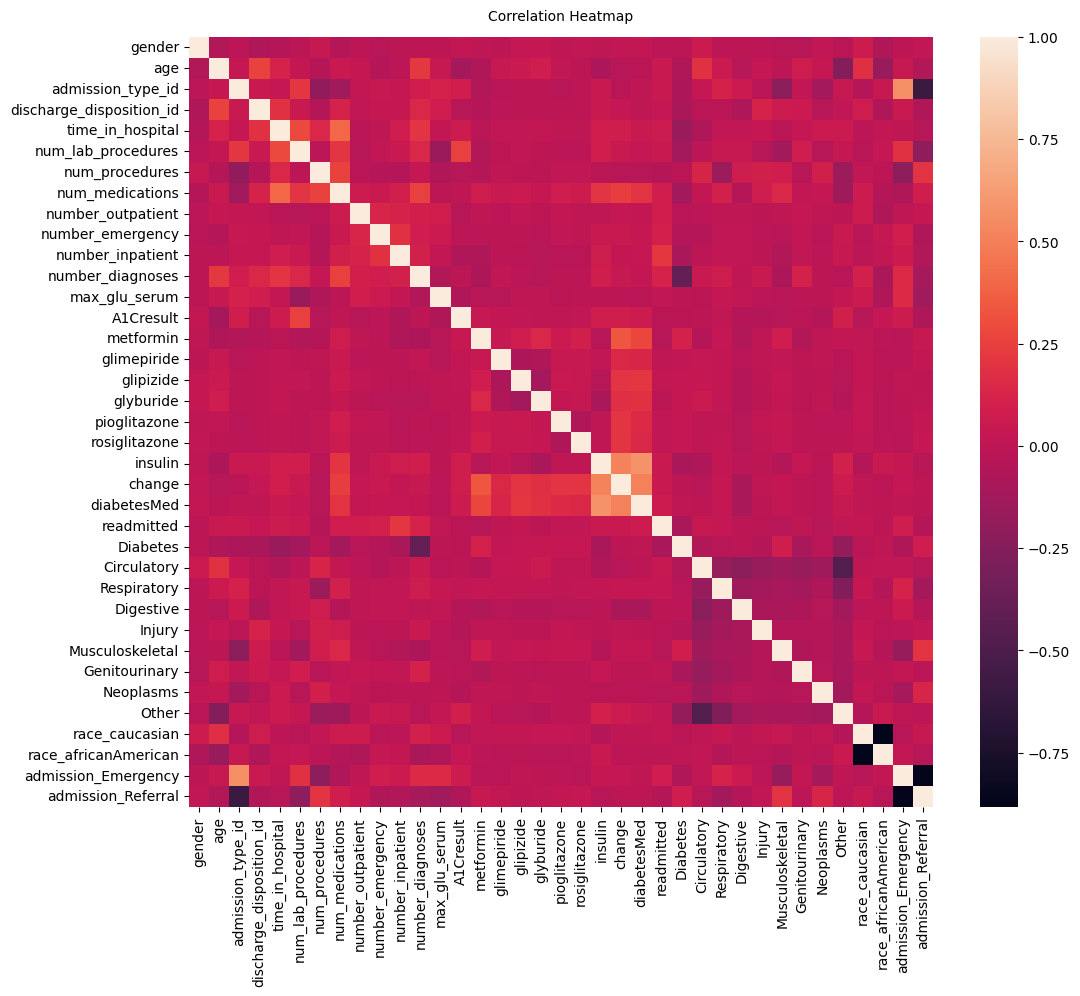

In [133]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df.corr())
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12)
plt.show()

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85040 entries, 0 to 85039
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   gender                    85040 non-null  int64
 1   age                       85040 non-null  int64
 2   admission_type_id         85040 non-null  int64
 3   discharge_disposition_id  85040 non-null  int64
 4   time_in_hospital          85040 non-null  int64
 5   num_lab_procedures        85040 non-null  int64
 6   num_procedures            85040 non-null  int64
 7   num_medications           85040 non-null  int64
 8   number_outpatient         85040 non-null  int64
 9   number_emergency          85040 non-null  int64
 10  number_inpatient          85040 non-null  int64
 11  number_diagnoses          85040 non-null  int64
 12  max_glu_serum             85040 non-null  int64
 13  A1Cresult                 85040 non-null  int64
 14  metformin                 85040 non-nu

In [136]:
df_copy_lg =df.copy()

In [137]:
df_copy_lg.shape

(85040, 37)

We performed dimensional reduction, as some models like hard margin SVM, KNN are resource intensive. In order to do that we performed PCA.

In [138]:
class PCA:
    def __init__(self,X):
        self.X=X

    def cum_explained_variance(X):

        num_components = X.shape[1]

        X_meaned = X - np.mean(X , axis = 0)

        cov_mat = np.cov(X_meaned , rowvar = False)

        eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
        
        sorted_index = np.argsort(eigen_values)[::-1]
        sorted_eigenvalue = eigen_values[sorted_index]
        explained_variance_ratio = [i/np.sum(eigen_values) for i in sorted_eigenvalue[:num_components]]
        cum_explained_variance = np.cumsum(explained_variance_ratio)
        return cum_explained_variance


    def fit(X,num_components):
 
        X_meaned = X - np.mean(X , axis = 0)

        cov_mat = np.cov(X_meaned , rowvar = False)

        eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

        sorted_index = np.argsort(eigen_values)[::-1]
        sorted_eigenvectors = eigen_vectors[:,sorted_index]
        
        eigenvector_subset = sorted_eigenvectors[:,0:num_components]
        X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
        principalDf = pd.DataFrame(data = X_reduced)
        principalDf.columns = ['PC{}'.format(i) for i in range (1, len(principalDf.columns)+1)]
        
        return principalDf

In [139]:
X = df_copy_lg.drop('readmitted',axis=1)
y = df_copy_lg['readmitted']

In [140]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [141]:
cum_explained_variance = PCA.cum_explained_variance(X)
cum_explained_variance

array([0.07964939, 0.15154474, 0.2133044 , 0.26637463, 0.31314061,
       0.3526401 , 0.38867686, 0.4236005 , 0.45689084, 0.48862694,
       0.51984775, 0.55003461, 0.58018044, 0.60962192, 0.63878915,
       0.66681649, 0.69415832, 0.72098528, 0.74673568, 0.77164113,
       0.79609153, 0.81953728, 0.84259454, 0.8636889 , 0.8842337 ,
       0.90231358, 0.91923057, 0.93511205, 0.95000628, 0.96368363,
       0.97674173, 0.98866352, 0.99342997, 0.99680263, 1.        ,
       1.        ])

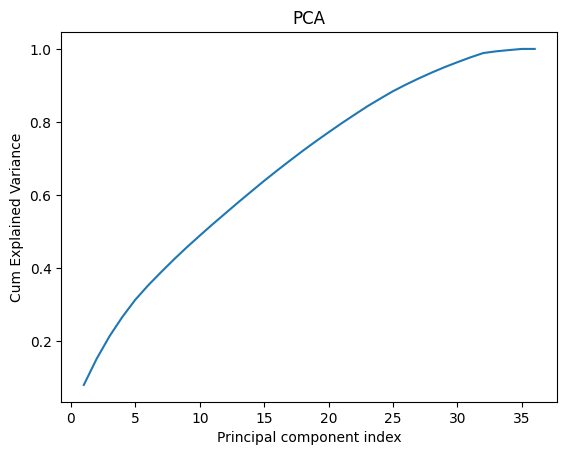

In [142]:
plt.plot(list(range(1,X.shape[1]+1)),cum_explained_variance)
plt.title('PCA')
plt.xlabel('Principal component index')
plt.ylabel('Cum Explained Variance')
plt.show()

We chose to select the first 30 principal components, which captured 97% of the total explained variance, after considering the tradeoff variance between these two factors!

In [143]:
X = PCA.fit(X,30)
X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,-1.417749,-0.704132,-1.791557,0.179757,-2.602586,-1.165659,0.621959,-0.249004,-0.233614,-0.013873,...,0.476233,-0.193958,0.769044,-0.831726,-0.150372,0.405825,0.653612,2.025278,-0.252786,-0.445645
1,0.924548,1.467049,-3.306912,0.384081,0.460434,1.573726,0.325988,2.019969,-1.460820,0.305647,...,0.187636,-1.360832,2.094275,-1.451466,-1.667381,-3.216812,-1.422520,0.812306,-0.184765,-0.903517
2,-0.834621,-0.380694,-1.452359,-0.643293,-1.677501,-1.011401,1.226839,-0.510048,-0.929906,-0.046430,...,0.484441,-0.115650,0.625573,-0.918692,-0.143393,0.045347,0.499840,0.767162,-0.269263,0.253918
3,0.349702,-0.119809,-1.304894,-2.011513,-0.291506,-0.763256,0.786732,1.490097,-0.168938,-2.623498,...,3.269085,0.440111,0.901529,0.476657,-0.674191,0.375807,1.177198,1.567881,0.116035,-0.129895
4,2.093424,-2.876171,0.215056,-0.374484,1.053089,-1.237885,1.478247,-1.054932,0.494528,-0.602968,...,-0.619515,-2.206867,-1.036572,-0.472044,0.206811,1.300599,1.274614,0.523925,-1.083087,0.558073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85035,-2.063329,-1.996501,-1.392906,2.020359,0.548496,3.400137,1.814757,0.967129,0.201758,2.373079,...,0.166862,1.576117,2.487611,-1.200759,-0.227880,0.670940,-0.516896,-0.066019,0.282850,0.601743
85036,-2.073618,-1.202531,-2.560358,1.004099,0.115916,-0.497715,-1.250318,-1.702878,-0.006298,0.779866,...,1.255635,-0.223608,-0.986643,-0.199602,1.858040,-0.733207,-0.671694,-0.045609,-1.043603,0.174087
85037,-0.335555,0.069778,-0.428731,3.173377,0.489176,1.058458,-0.697640,0.883744,-1.534307,-1.624627,...,0.001539,0.321396,-0.355158,-0.129645,0.319065,-1.640844,-0.277923,-0.658959,-0.227177,-0.774939
85038,-1.754830,-3.094777,1.791159,0.837010,-0.385649,0.601489,-2.680183,-0.284188,-2.713657,-1.436199,...,-1.256027,1.050002,0.836054,0.588415,-0.560069,-0.026808,-0.397099,-0.141621,0.819215,0.167014


In [144]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)
SC = StandardScaler()


X_train.reset_index(inplace = True)
X_train.drop("index",axis = 1,inplace=True)
X_train = X_train.squeeze()
X_test.reset_index(inplace = True)
X_test.drop("index",axis = 1,inplace=True)
X_test = X_test.squeeze()



d = y_train.reset_index(name='values')
y_train = d.drop("index",axis = 1).squeeze()


d = y_test.reset_index(name='values')
y_test = d.drop("index",axis = 1).squeeze()

In [145]:
X_train.shape,X_test.shape,X_train.shape,X_test.shape

((59528, 30), (25512, 30), (59528, 30), (25512, 30))

In [146]:
def confusion(true, pred):

    classes = np.unique(true) 
    matrix = np.zeros((len(classes), len(classes)))  
    print(true.shape)
    for i in range(len(classes)):
        for j in range(len(classes)):
            matrix[i, j] = np.sum((true == classes[i]) & (pred == classes[j]))

    conf_df = pd.DataFrame(data=matrix,
                          index=["Actual "+str(classes[0]), "Actual "+str(classes[1])],
                          columns=["Predicted "+str(classes[0]), "Predicted "+str(classes[1])])
    return conf_df

def Eval(true, pred):

    _NUMERIC_KINDS = set('buifc')
    true = np.array(true)
    pred = np.array(pred)

    if(len(true) == len(pred)):

        
        if (not(true.dtype.kind in _NUMERIC_KINDS) or not(pred.dtype.kind in _NUMERIC_KINDS)):
            print("There is a non-numeric array instead of a numeric array.")

        else:
            true_unique = np.sort(np.unique(true))
            pred_unique = np.sort(np.unique(pred))


            if (np.array_equal(true_unique, pred_unique)):

                if(len(true_unique) == 2):


                    confusionMatrix = confusion(true, pred)
                    tp = confusionMatrix.iloc[1, 1]
                    tn = confusionMatrix.iloc[0, 0]
                    fp = confusionMatrix.iloc[0, 1]
                    fn = confusionMatrix.iloc[1, 0]

                    print("\nConfusion Matrix is as follows (class 1 is target class)\n", confusionMatrix)
                    print("\nAccuracy is ", round(((tp+tn)/(tn+fp+fn+tp))*100,2),"%")
                    print("Error is ", round((1-((tp+tn)/(tn+fp+fn+tp)))*100,2),"%")
                    print("Recall is ", round(((tp)/(fn+tp))*100,2),"%")
                    print("Precision is ", round(((tp)/(fp+tp))*100,2),"%")
                else:
                    print("Detected non-binary classification outcome")
            else:
                print("Different classification is present inside arrays.")
    else:
        print("Array length is not constant when calculating performance")

With Logistic regression, the input is multiplied by the optimal parameters learned through iterations and the output we get will be a sigmoid function which will give the probability between 0 and 1. Then with the threshold value we decided, we will group them into 1 and 0. In order to achieve a higher recall and accuracy we will try to optimize the parameters such as learning rate, epsilon, regularization term and threshold.

In [147]:
@dataclass
class LogisticRegression:
    learning_rate: float
    max_iterations: int
    epsilon: float
    tol: float
    lam: float

    
    def __post_init__(self):
        self.read_dataset()
    
    def read_dataset(self):
#         self.X = df_copy_lg.drop('readmitted',axis=1)
#         self.y = df_copy_lg['readmitted']
        self.X_train, self.X_test, self.y_train, self.y_test = X_train,X_test,y_train,y_test
#         self.X_train = pd.DataFrame(SC.fit_transform(self.X_train),columns=X_train.columns)
#         self.X_test = pd.DataFrame(SC.transform(self.X_test),columns=X_test.columns)
    
    def cost_function(self, X, y):
        pred_ = np.log(np.ones(X.shape[0]) + np.exp(X.dot(self.w))) - X.dot(self.w).dot(y)  # Neg Log Likelihood
        reg_term = 0.5 * self.lam * np.sum(self.w ** 2)   
        cost = pred_.sum() + reg_term 
        return cost

    def sigmoid(self, z):
        sig = 1 / (1 + np.exp(-z))
        return sig
    
    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        return (sig - y).dot(X)
    
    def gradient_descent(self, X, y):
        errors = []
        prev_error = float('inf')
        for i in tqdm(range(self.max_iterations), colour='red'):
            self.w = self.w - self.learning_rate * self.gradient(X, y)
            current_error = self.cost_function(X, y)
            errors.append(current_error)
            if np.abs(prev_error - current_error) < self.epsilon:
                print("The model stopped learning")
                break
            prev_error = current_error
        self.plot_cost(errors)   
    
    def predict(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        self.plot_dist(y,sig)
        for i in range(len(sig)):

            if sig[i] >= self.tol:
          
              
              sig[i] = 1
            
            else:

              sig[i] =0  
        return sig
    
    def evaluate(self, y, y_hat):
        y = y == 1
        y_hat = y_hat == 1
        
        
        xx = y_hat == 0
        xxx = y ==0

        precision = (y & y_hat).sum()  / (y_hat.sum())
        accuracy = ((y & y_hat).sum() + (xx & xxx).sum()) / (y_hat.sum() + xx.sum())
        print( "accuracy is {}".format(accuracy))
        recall = (y & y_hat).sum() / y.sum()
        f_score = 2 * (precision * recall) / (precision + recall)
        return precision, recall, f_score
        
    def runModel(self, remove_indices = None):

        print("Before Removing Indices: ", self.X_train.shape)
        
        if remove_indices:
            self.X_train = self.remove_indices(self.X_train, remove_indices)
            self.y_train = self.remove_indices(self.y_train, remove_indices)
                    
                
        print("After Removing Indices: ", self.X_train.shape)
        
        
        print("Solving using gradient descent")
        self.w = np.zeros(self.X_train.shape[1], dtype=np.float64)
        self.gradient_descent(self.X_train, self.y_train)
        
        print(self.w)
        
        y_hat_train = self.predict(self.X_train, self.y_train)
        precision, recall, f_score = self.evaluate(self.y_train, y_hat_train)
        
        print("The model has a precision of {}".format(precision))
        print("The model has a recall of {}".format(recall))
        print("The model has a f_score of {}".format(f_score))
    
    
    def remove_indices(self, X, indices):
        
        X = np.delete(X, indices, axis=0)
        return X

    def plot_dist(self, y, y_hat):
      y_hat_1 = y_hat[y==1]
      y_hat_0 = y_hat[y==0]
      #plt.hist([y_hat_1, y_hat_0], label=['1, 0'], bins=50, alpha=0.8)
      #plt.legend(loc='upper right')
      #plt.show()
      #plt.xlabel("Predicted probability distribution")

      sns.distplot(y_hat_1, hist=False, rug=True)
      sns.distplot(y_hat_0, hist=False, rug=True)

      plt.show()
        

    def plot_cost(self, cost_sequence):
        
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        
        fig, ax = plt.subplots()
        ax.plot(t,s)
        
        ax.set(xlabel='Iterations', ylabel='Cost', title='Cost trend')
        ax.grid()
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, shadow=True)
        plt.show()

Before Removing Indices:  (59528, 30)
After Removing Indices:  (59528, 30)
Solving using gradient descent


100%|██████████| 10000/10000 [01:39<00:00, 100.41it/s]


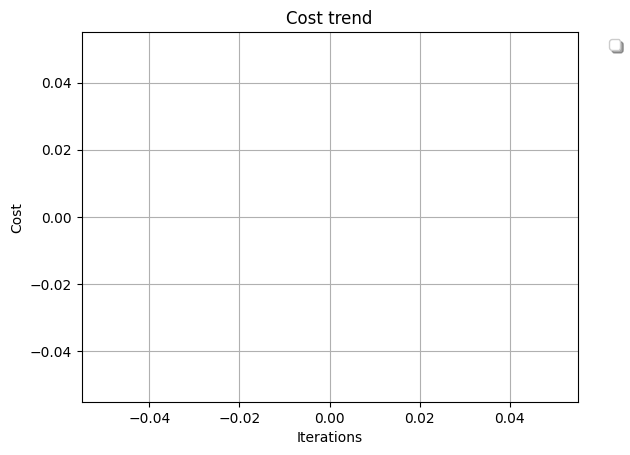

PC1     760.042491
PC2    -729.505417
PC3     339.989456
PC4     465.316451
PC5    -200.672718
PC6     572.010721
PC7     689.262970
PC8    -122.487672
PC9     362.227338
PC10    336.572586
PC11   -192.309132
PC12    -26.337098
PC13    -29.189690
PC14    105.450451
PC15     50.266782
PC16    -53.573727
PC17      7.630525
PC18    527.683452
PC19    242.138836
PC20     44.635167
PC21   -370.465633
PC22   -123.362995
PC23    234.498557
PC24    351.298287
PC25    -32.742729
PC26     53.506837
PC27    -38.798061
PC28   -249.744602
PC29     79.282791
PC30   -478.559582
dtype: float64


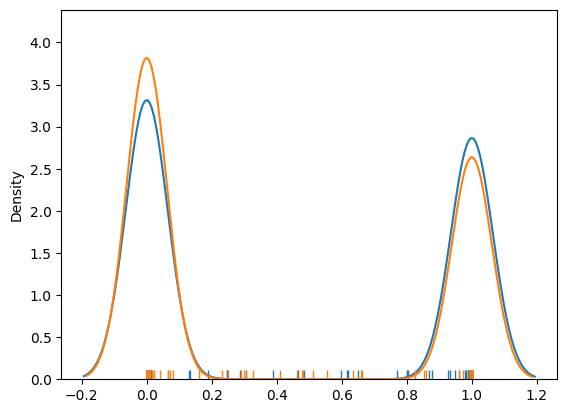

accuracy is 0.5319849482596425
The model has a precision of 0.49568682062589453
The model has a recall of 0.46365379744545354
The model has a f_score of 0.4791355070296141


In [ ]:
lr = LogisticRegression(epsilon=0.0001, learning_rate=0.1, max_iterations=10000, tol = 0.4, lam = 0.0001)
lr.runModel()

Before Removing Indices:  (59528, 30)
After Removing Indices:  (59528, 30)
Solving using gradient descent


100%|██████████| 10000/10000 [01:39<00:00, 100.02it/s]


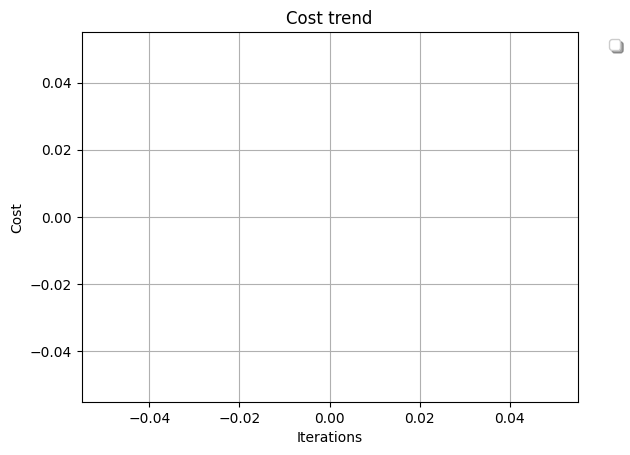

PC1     75.895596
PC2    -72.903211
PC3     33.972527
PC4     46.507683
PC5    -20.000626
PC6     57.178846
PC7     68.885193
PC8    -12.314444
PC9     36.177329
PC10    33.688500
PC11   -19.245405
PC12    -2.658267
PC13    -2.985458
PC14    10.582868
PC15     5.035625
PC16    -5.369070
PC17     0.766051
PC18    52.714747
PC19    24.163785
PC20     4.507064
PC21   -37.105392
PC22   -12.285158
PC23    23.425630
PC24    35.164350
PC25    -3.296599
PC26     5.388547
PC27    -3.955195
PC28   -24.971027
PC29     7.944274
PC30   -47.950641
dtype: float64


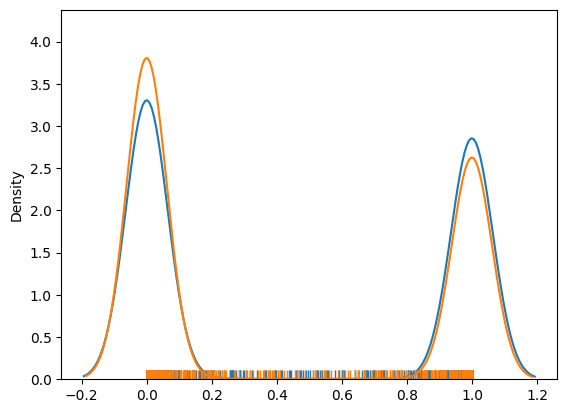

accuracy is 0.5320017470770058
The model has a precision of 0.4957099791296282
The model has a recall of 0.46408799797373085
The model has a f_score of 0.4793780717983218


In [ ]:
lr = LogisticRegression(epsilon=0.0001, learning_rate=0.01, max_iterations=10000, tol = 0.4, lam = 0.0001)
lr.runModel()

Before Removing Indices:  (59528, 30)
After Removing Indices:  (59528, 30)
Solving using gradient descent


100%|██████████| 10000/10000 [01:38<00:00, 101.79it/s]


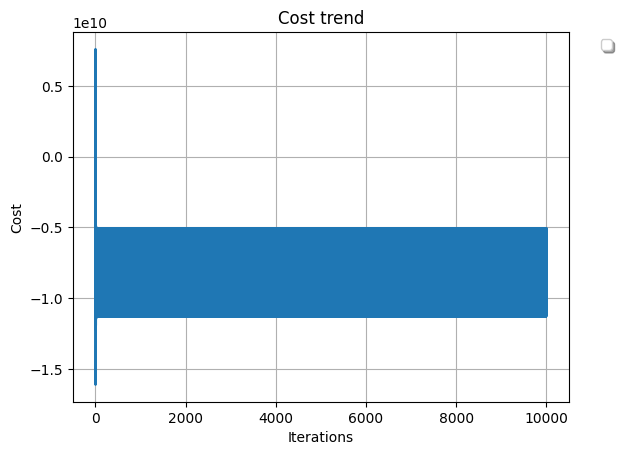

PC1     7.641417
PC2    -7.286874
PC3     3.359263
PC4     4.642544
PC5    -1.990566
PC6     5.698370
PC7     6.891219
PC8    -1.212135
PC9     3.604496
PC10    3.390598
PC11   -1.913730
PC12   -0.283290
PC13   -0.325680
PC14    1.066499
PC15    0.519471
PC16   -0.532646
PC17    0.108729
PC18    5.248086
PC19    2.419574
PC20    0.440962
PC21   -3.727540
PC22   -1.226127
PC23    2.314745
PC24    3.500712
PC25   -0.320516
PC26    0.547005
PC27   -0.417038
PC28   -2.493049
PC29    0.824248
PC30   -4.766859
dtype: float64


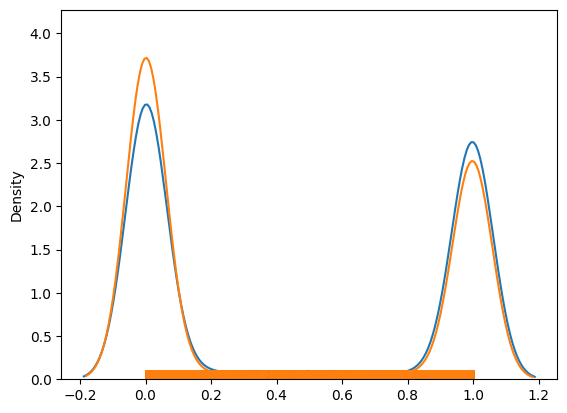

accuracy is 0.5319009541728262
The model has a precision of 0.49563519411899837
The model has a recall of 0.4683938198791475
The model has a f_score of 0.4816296158496884


In [ ]:
lr = LogisticRegression(epsilon=0.0001, learning_rate=0.001, max_iterations=10000,  tol = 0.4, lam = 0.0001)
lr.runModel()

Before Removing Indices:  (59528, 30)
After Removing Indices:  (59528, 30)
Solving using gradient descent


100%|██████████| 10000/10000 [01:30<00:00, 110.00it/s]


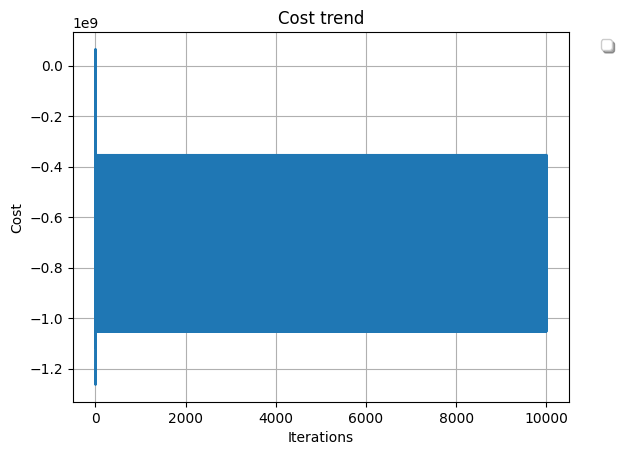

PC1     0.876211
PC2    -0.588179
PC3     0.232757
PC4     0.343394
PC5    -0.171691
PC6     0.516959
PC7     0.626455
PC8    -0.014360
PC9     0.229847
PC10    0.331830
PC11   -0.186185
PC12   -0.060256
PC13   -0.081315
PC14    0.076741
PC15   -0.020553
PC16   -0.064294
PC17    0.110628
PC18    0.443558
PC19    0.241827
PC20    0.121308
PC21   -0.322096
PC22   -0.150423
PC23    0.222304
PC24    0.321381
PC25    0.019450
PC26   -0.034554
PC27   -0.049000
PC28   -0.180081
PC29    0.073680
PC30   -0.283768
dtype: float64


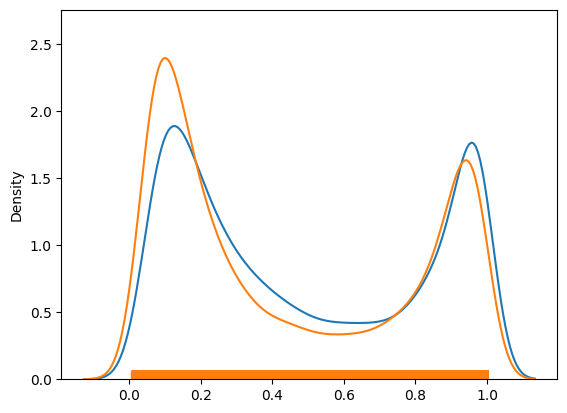

accuracy is 0.5291963445773418
The model has a precision of 0.4929801133287617
The model has a recall of 0.49422875131164745
The model has a f_score of 0.4936036426712923


In [ ]:
lr = LogisticRegression(epsilon=0.0001, learning_rate=0.0001, max_iterations=10000, tol = 0.4, lam = 0.0001)
lr.runModel()

Before Removing Indices:  (59528, 30)
After Removing Indices:  (59528, 30)
Solving using gradient descent


  3%|▎         | 324/10000 [00:04<02:01, 79.68it/s]


The model stopped learning


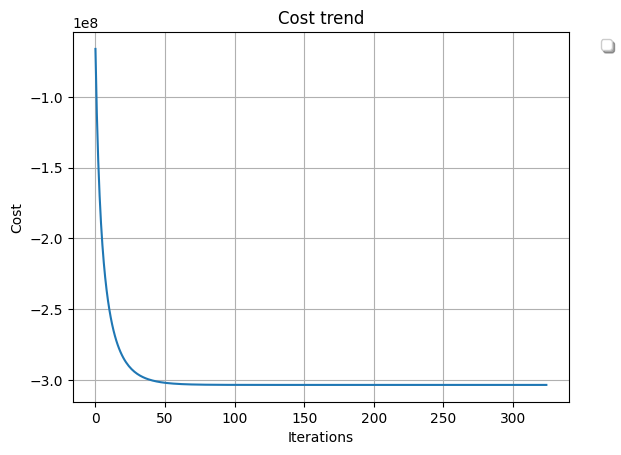

PC1    -0.164763
PC2    -0.104664
PC3     0.089344
PC4     0.091813
PC5    -0.044761
PC6     0.226704
PC7     0.230494
PC8     0.031520
PC9     0.080543
PC10    0.137173
PC11   -0.084406
PC12   -0.038774
PC13   -0.042511
PC14    0.033055
PC15   -0.014541
PC16   -0.018844
PC17    0.022490
PC18    0.149682
PC19    0.114302
PC20    0.101807
PC21   -0.070813
PC22   -0.061548
PC23    0.102145
PC24    0.169347
PC25    0.014635
PC26   -0.010266
PC27   -0.039288
PC28   -0.030840
PC29   -0.016639
PC30   -0.031488
dtype: float64


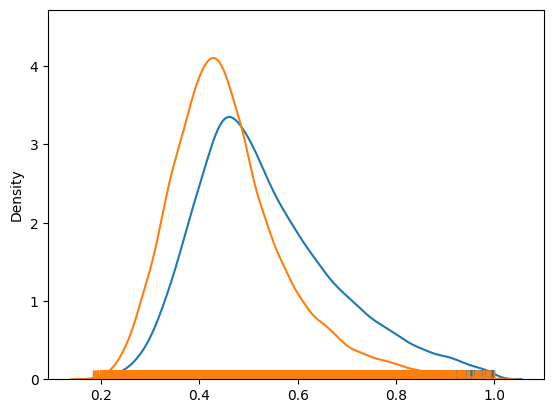

accuracy is 0.563835505980379
The model has a precision of 0.5186656253486556
The model has a recall of 0.8410464232731483
The model has a f_score of 0.6416386021089824


In [ ]:
lr = LogisticRegression(epsilon=0.0001, learning_rate=0.00001, max_iterations=10000, tol = 0.4, lam = 0.0001)
lr.runModel()

Before Removing Indices:  (59528, 30)
After Removing Indices:  (59528, 30)
Solving using gradient descent


 30%|███       | 3034/10000 [00:27<01:03, 109.72it/s]


The model stopped learning


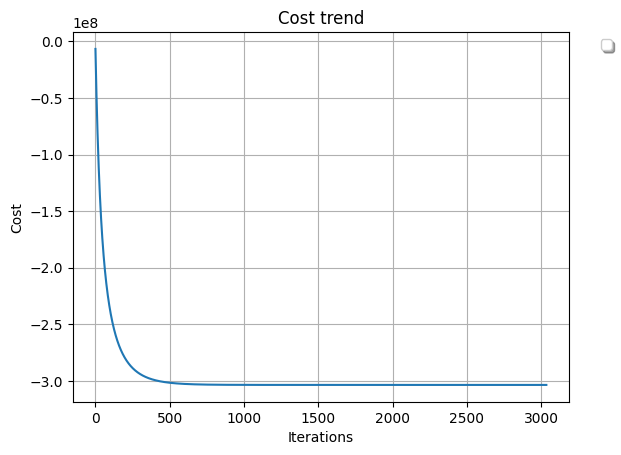

PC1    -0.164763
PC2    -0.104664
PC3     0.089344
PC4     0.091813
PC5    -0.044761
PC6     0.226704
PC7     0.230494
PC8     0.031520
PC9     0.080543
PC10    0.137173
PC11   -0.084406
PC12   -0.038774
PC13   -0.042511
PC14    0.033055
PC15   -0.014541
PC16   -0.018844
PC17    0.022490
PC18    0.149682
PC19    0.114302
PC20    0.101807
PC21   -0.070813
PC22   -0.061548
PC23    0.102145
PC24    0.169347
PC25    0.014635
PC26   -0.010266
PC27   -0.039288
PC28   -0.030840
PC29   -0.016639
PC30   -0.031488
dtype: float64


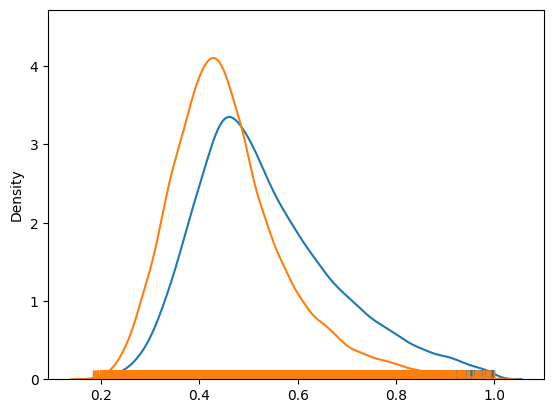

accuracy is 0.563835505980379
The model has a precision of 0.5186656253486556
The model has a recall of 0.8410464232731483
The model has a f_score of 0.6416386021089824


In [ ]:
lr = LogisticRegression(epsilon=0.0001, learning_rate=0.000001, max_iterations=10000, tol = 0.4, lam = 0.0001)
lr.runModel()

Before Removing Indices:  (59528, 30)
After Removing Indices:  (59528, 30)
Solving using gradient descent


 27%|██▋       | 27268/100000 [04:12<11:13, 107.95it/s]


The model stopped learning


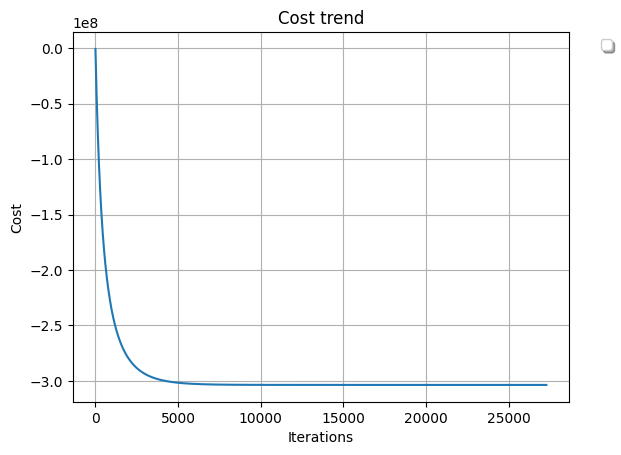

PC1    -0.164763
PC2    -0.104664
PC3     0.089344
PC4     0.091813
PC5    -0.044761
PC6     0.226704
PC7     0.230494
PC8     0.031520
PC9     0.080543
PC10    0.137173
PC11   -0.084406
PC12   -0.038774
PC13   -0.042511
PC14    0.033055
PC15   -0.014541
PC16   -0.018844
PC17    0.022490
PC18    0.149682
PC19    0.114302
PC20    0.101807
PC21   -0.070813
PC22   -0.061548
PC23    0.102145
PC24    0.169347
PC25    0.014635
PC26   -0.010266
PC27   -0.039288
PC28   -0.030840
PC29   -0.016639
PC30   -0.031488
dtype: float64


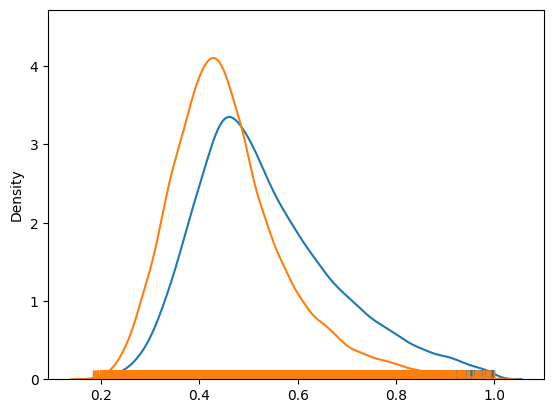

accuracy is 0.563835505980379
The model has a precision of 0.5186656253486556
The model has a recall of 0.8410464232731483
The model has a f_score of 0.6416386021089824


In [ ]:
lr = LogisticRegression(epsilon=0.0001, learning_rate=0.0000001, max_iterations=100000, tol = 0.4, lam = 0.0001)
lr.runModel()

Before Removing Indices:  (59528, 30)
After Removing Indices:  (59528, 30)
Solving using gradient descent


 30%|███       | 3034/10000 [00:28<01:06, 105.31it/s]


The model stopped learning


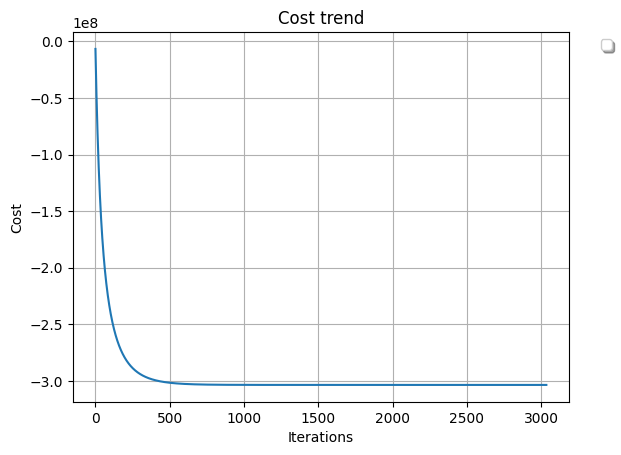

PC1    -0.164763
PC2    -0.104664
PC3     0.089344
PC4     0.091813
PC5    -0.044761
PC6     0.226704
PC7     0.230494
PC8     0.031520
PC9     0.080543
PC10    0.137173
PC11   -0.084406
PC12   -0.038774
PC13   -0.042511
PC14    0.033055
PC15   -0.014541
PC16   -0.018844
PC17    0.022490
PC18    0.149682
PC19    0.114302
PC20    0.101807
PC21   -0.070813
PC22   -0.061548
PC23    0.102145
PC24    0.169347
PC25    0.014635
PC26   -0.010266
PC27   -0.039288
PC28   -0.030840
PC29   -0.016639
PC30   -0.031488
dtype: float64


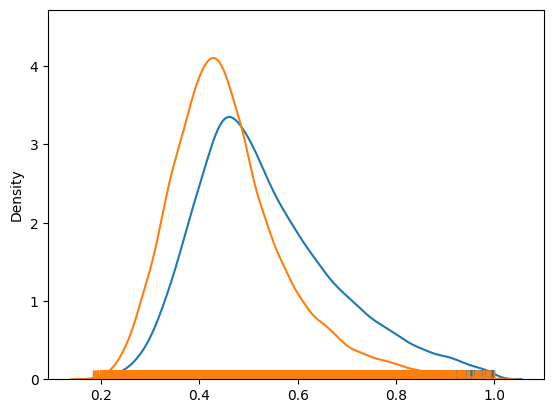

accuracy is 0.6048918156161807
The model has a precision of 0.5603082061348256
The model has a recall of 0.6920070919419619
The model has a f_score of 0.6192326372025255


In [ ]:
lr = LogisticRegression(epsilon=0.0001, learning_rate=0.000001, max_iterations=10000, tol = 0.45, lam = 0.0001)
lr.runModel()

From the models we trained, based ona ccuracy adn recall we choose the one with following parameters: learning rate: 0.00001, threshold = 0.45, lambda = 0.003. For this model we got accuracy of 0.605 and recall of 69.2. 

In [ ]:
class NaiveBayes:
    
    def __init__(self, X, y, tau = 1, L = 2, discrete = False):
        self.X = X
        self.y = y
        self.tau = tau
        # tau = Laplace smoothing parameter
        self.discrete = discrete
        #discrete = A boolean value which says if the input data is discrete or not
        self.classes = L
        # L = The number of labels / classes
        
    def splitData(self):
        self.X_train, self.X_test, self.y_train, self.y_test =  X_train, X_test, y_train, y_test

    def likelihood(self, data):
        mu = np.mean(data)
        sigma = np.std(data)
        dist = norm(mu, sigma)
        return dist
    
    def posterior(self, x, prior, label):
        
        if not self.discrete:
            dist1 = self.dist_X0y0 if label == 0 else self.dist_X0y1
            dist2 = self.dist_X1y0 if label == 0 else self.dist_X1y1
            return prior * dist1.pdf(x[0]) * dist2.pdf(x[1])
        else:
            ans = prior
            if label == 0:
                if x[0] == 0:
                    ans *= self.prob_X00y0
                elif x[0] == 1:
                    ans *= self.prob_X01y0

                if x[1] == 0:
                    ans *= self.prob_X10y0
                elif x[1] == 1:
                    ans *= self.prob_X11y0

            elif label == 1:
                if x[0] == 0:
                    ans *= self.prob_X00y1
                elif x[0] == 1:
                    ans *= self.prob_X01y1

                if x[1] == 0:
                    ans *= self.prob_X10y1
                elif x[1] == 1:
                    ans *= self.prob_X11y1

            return ans
                
    
    def fit(self):
        self.splitData()
        
        self.X0_train = self.X_train[self.y_train == 0]
        self.X1_train = self.X_train[self.y_train == 1]
        # Calculate Priors
        self.prior_y0 = len(self.X0_train) / len(self.X_train)
        self.prior_y1 = len(self.X1_train) / len(self.X_train)
        
        
        if self.discrete:
            # X0 = 0, Y = 0
            self.prob_X00y0 = (self.X0_train[np.where(self.X0_train[:,0] == 0)].shape[0] + self.tau)/(len(self.X0_train) + self.classes*self.tau)
            # X0 = 1, Y = 0
            self.prob_X01y0 = (self.X0_train[np.where(self.X0_train[:,0] == 1)].shape[0] + self.tau)/(len(self.X0_train) + self.classes*self.tau)

            # X1 = 0, Y = 0
            self.prob_X10y0 = (self.X0_train[np.where(self.X0_train[:,1] == 0)].shape[0] + self.tau)/(len(self.X0_train) + self.classes*self.tau)
            # X1 = 1, Y = 0
            self.prob_X11y0 = (self.X0_train[np.where(self.X0_train[:,1] == 1)].shape[0] + self.tau)/(len(self.X0_train) + self.classes*self.tau)


            # X0 = 0, Y = 1
            self.prob_X00y1 = (self.X1_train[np.where(self.X1_train[:,0] == 0)].shape[0] + self.tau)/ (len(self.X1_train) + self.classes*self.tau)
            # X0 = 1, Y = 1
            self.prob_X01y1 = (self.X1_train[np.where(self.X1_train[:,0] == 1)].shape[0] + self.tau)/ (len(self.X1_train) + self.classes*self.tau)

            # X1 = 0, Y = 1
            self.prob_X10y1 = (self.X1_train[np.where(self.X1_train[:,1] == 0)].shape[0] + self.tau)/ (len(self.X1_train) + self.classes*self.tau)

            # X1 = 1, Y = 1
            self.prob_X11y1 = (self.X1_train[np.where(self.X1_train[:,1] == 1)].shape[0] + self.tau)/ (len(self.X1_train) + self.classes*self.tau)
        
        else:
            
            # Create PDFs for class 0
            self.dist_X0y0 = self.likelihood(self.X0_train.iloc[:, 0])
            self.dist_X1y0 = self.likelihood(self.X0_train.iloc[:, 1])

            # Create PDFs for class 1
            self.dist_X0y1 = self.likelihood(self.X1_train.iloc[:, 0])
            self.dist_X1y1 = self.likelihood(self.X1_train.iloc[:, 1])
        
        
    
    def predict(self):
        #print(self.X_test.columns)
        #print(self.y_test)
        a = []
        for i in range(0,len(X_test)):
            py0 = self.posterior(X_test.iloc[i,:], self.prior_y0, label = 0)
            py1 = self.posterior(X_test.iloc[i,:], self.prior_y1, label = 1)
            
            a.append(np.argmax([py0,py1]))
            #print('P(y=0| %s) = %.3f' % (sample, py0))
            #print('P(y=1| %s) = %.3f' % (sample, py1))
            #print("Target was class {} and model predicted class{}".format(y_test[i], np.argmax([py0*100, py1*100])))
        return a

In [ ]:
nb = NaiveBayes(X, y, tau = 1, discrete = False, L = 2)

In [ ]:
nb.fit()

In [ ]:
val = nb.predict()
Eval(y_test, val)

(25512,)

Confusion Matrix is as follows (class 1 is target class)
           Predicted 0  Predicted 1
Actual 0       8356.0       5399.0
Actual 1       5882.0       5875.0

Accuracy is  55.78 %
Error is  44.22 %
Recall is  49.97 %
Precision is  52.11 %


Considering the dataset is related to patient healthcare, we should give more importance to recall. So this model is not suitable for our business requirement.

In [ ]:
class HardMarginSVM_ML:
    
    def __init__(self, X_train, X_test, y_train, y_test, learning_rate = 0.00001, lamda = 0.001, n_iters = 1000):
        self.learning_rate = learning_rate
        self.lamda = lamda
        self.n_iters = n_iters
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.w = None
        self.b = None


    def fit(self):
        self.y_test = np.where(self.y_test<=0, -1, self.y_test)
        self.y_train = np.where(self.y_train<=0, -1, self.y_train) #convert y values to -1 and +1 
        n_samples, n_features = self.X_train.shape
        
        self.w = np.zeros(n_features)
        self.b = 0
        
        for i in range(self.n_iters):
            for idx in range(0,len(X_train)):
#             for idx, x_i in enumerate(self.X_train):x
#                 print(x_i)
                condition = self.y_train[idx] * (np.dot(X_train.iloc[idx,:], self.w) + self.b) >=1
                
                if condition:
                    self.w = self.w + self.learning_rate *(2 * self.lamda * self.w)
                else:
                    self.w = self.w - self.learning_rate *(2 * self.lamda * self.w - np.dot(X_train.iloc[idx,:], 
                                                                                            self.y_train[idx]))
                    self.b = self.b - self.learning_rate * (-self.y_train[idx])
    

    def predict(self):
        print("\n----------------------------------------------------------") 
        print("\nEvaluation for training data:")
        approx = np.dot(self.X_train,self.w) + self.b
        y_hat_train = np.sign(approx)
        y_hat_train = y_hat_train.astype(int)
        true_unique = np.sort(np.unique(self.y_train))
        pred_unique = np.sort(np.unique(y_hat_train))
        print(true_unique)
        print(pred_unique)
        Eval(self.y_train, y_hat_train)
        
        print(len(self.y_train))

        print("\n----------------------------------------------------------") 
        print("\nEvaluation for testing data:")
        approx = np.dot(self.X_test,self.w) + self.b
        y_hat_test = np.sign(approx)
        y_hat_test = y_hat_test.astype(int)
        true_unique = np.sort(np.unique(self.y_test))
        pred_unique = np.sort(np.unique(y_hat_test))
        print(true_unique)
        print(pred_unique)
        Eval(self.y_test,y_hat_test)

In [ ]:
clf = HardMarginSVM_ML(X_train,X_test,y_train,y_test, learning_rate = 0.000001, lamda = 0.00001, n_iters = 100)
clf.fit()
clf.predict()


----------------------------------------------------------

Evaluation for training data:
[-1  1]
[-1  1]
(59528,)

Confusion Matrix is as follows (class 1 is target class)
            Predicted -1  Predicted 1
Actual -1       26071.0       5820.0
Actual 1        17179.0      10458.0

Accuracy is  61.36 %
Error is  38.64 %
Recall is  37.84 %
Precision is  64.25 %
59528

----------------------------------------------------------

Evaluation for testing data:
[-1  1]
[-1  1]
(25512,)

Confusion Matrix is as follows (class 1 is target class)
            Predicted -1  Predicted 1
Actual -1       11244.0       2511.0
Actual 1         7400.0       4357.0

Accuracy is  61.15 %
Error is  38.85 %
Recall is  37.06 %
Precision is  63.44 %


In [ ]:
clf = HardMarginSVM_ML(X_train,X_test,y_train,y_test, learning_rate = 0.1, lamda = 0.001, n_iters = 100)
clf.fit()
clf.predict()


----------------------------------------------------------

Evaluation for training data:
[-1  1]
[-1  1]
(59528,)

Confusion Matrix is as follows (class 1 is target class)
            Predicted -1  Predicted 1
Actual -1       18965.0      12926.0
Actual 1        13276.0      14361.0

Accuracy is  55.98 %
Error is  44.02 %
Recall is  51.96 %
Precision is  52.63 %
59528

----------------------------------------------------------

Evaluation for testing data:
[-1  1]
[-1  1]
(25512,)

Confusion Matrix is as follows (class 1 is target class)
            Predicted -1  Predicted 1
Actual -1        8151.0       5604.0
Actual 1         5638.0       6119.0

Accuracy is  55.93 %
Error is  44.07 %
Recall is  52.05 %
Precision is  52.2 %


In [ ]:
clf = HardMarginSVM_ML(X_train,X_test,y_train,y_test, learning_rate = 0.001, lamda = 0.01, n_iters = 200)
clf.fit()
clf.predict()


----------------------------------------------------------

Evaluation for training data:
[-1  1]
[-1  1]
(59528,)

Confusion Matrix is as follows (class 1 is target class)
            Predicted -1  Predicted 1
Actual -1       27204.0       4687.0
Actual 1        18603.0       9034.0

Accuracy is  60.88 %
Error is  39.12 %
Recall is  32.69 %
Precision is  65.84 %
59528

----------------------------------------------------------

Evaluation for testing data:
[-1  1]
[-1  1]
(25512,)

Confusion Matrix is as follows (class 1 is target class)
            Predicted -1  Predicted 1
Actual -1       11751.0       2004.0
Actual 1         8002.0       3755.0

Accuracy is  60.78 %
Error is  39.22 %
Recall is  31.94 %
Precision is  65.2 %


Considering the dataset is related to patient healthcare, we should give more importance to recall. So this model is not suitable for our business requirement.

In [186]:
model1 = Sequential()

model1.add(Dense(units=16, activation='relu', input_dim=X.shape[1]))
model1.add(Dense(units=32, activation='relu'))
model1.add(Dense(units=8, activation='relu'))

# output layer
model1.add(Dense(units=1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.experimental.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
epochs=100
history1 = model1.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=124,
            validation_data= shuffle(X_test, y_test))

Epoch 1/100
481/481 [==============================] - 5s 6ms/step - loss: 0.7053 - accuracy: 0.5174 - val_loss: 0.6826 - val_accuracy: 0.5646
Epoch 2/100
481/481 [==============================] - 3s 6ms/step - loss: 0.6762 - accuracy: 0.5744 - val_loss: 0.6735 - val_accuracy: 0.5836
Epoch 3/100
481/481 [==============================] - 2s 5ms/step - loss: 0.6682 - accuracy: 0.5914 - val_loss: 0.6682 - val_accuracy: 0.5922
Epoch 4/100
481/481 [==============================] - 2s 4ms/step - loss: 0.6634 - accuracy: 0.6002 - val_loss: 0.6649 - val_accuracy: 0.5984
Epoch 5/100
481/481 [==============================] - 2s 4ms/step - loss: 0.6602 - accuracy: 0.6047 - val_loss: 0.6625 - val_accuracy: 0.6014
Epoch 6/100
481/481 [==============================] - 2s 5ms/step - loss: 0.6579 - accuracy: 0.6071 - val_loss: 0.6607 - val_accuracy: 0.6064
Epoch 7/100
481/481 [==============================] - 3s 7ms/step - loss: 0.6561 - accuracy: 0.6102 - val_loss: 0.6593 - val_accuracy: 0.6078

In [187]:
def convertArrayOfArray(arrayData):
  y_list = []
  for i in arrayData:
    y_list.append(i[0])
  return y_list

In [188]:
def findAccuracy(y_hat):
  y_hat[y_hat<.4] = 0
  y_hat[y_hat!=0] = 1

  y_hat_list = convertArrayOfArray(y_hat)

  df_dummy = pd.DataFrame()

  df_dummy["y_Hat"] = y_hat_list
  Eval( y_test, df_dummy["y_Hat"])

In [189]:
def lossPlot (history):
  # visualizing losses and accuracy
  train_loss = history.history['loss']
  val_loss   = history.history['val_loss']
  train_acc  = history.history['accuracy']
  val_acc    = history.history['val_accuracy']
  xc         = range(100)
  plt.figure(figsize=(12, 6))
  plt.plot(xc, train_loss, label="train")
  plt.plot(xc, val_loss, label="valdiation")
  plt.legend()
  plt.title("validation and train loss")
  plt.show()

In [190]:
def AccuracyPlot (history):
  # visualizing losses and accuracy
  train_loss = history.history['loss']
  val_loss   = history.history['val_loss']
  train_acc  = history.history['accuracy']
  val_acc    = history.history['val_accuracy']
  xc         = range(100)
  plt.figure(figsize=(12, 6))
  plt.plot(xc, train_acc, label="train")
  plt.plot(xc, val_acc, label="valdiation")
  plt.legend()
  plt.title("validation and train Accuracy")
  plt.show()

In [192]:
y_hat1 = model1.predict(X_test)
findAccuracy(y_hat1)

798/798 [==============================] - 2s 2ms/step
(25512,)

Confusion Matrix is as follows (class 1 is target class)
           Predicted 0  Predicted 1
Actual 0       6441.0       7314.0
Actual 1       2995.0       8762.0

Accuracy is  59.59 %
Error is  40.41 %
Recall is  74.53 %
Precision is  54.5 %


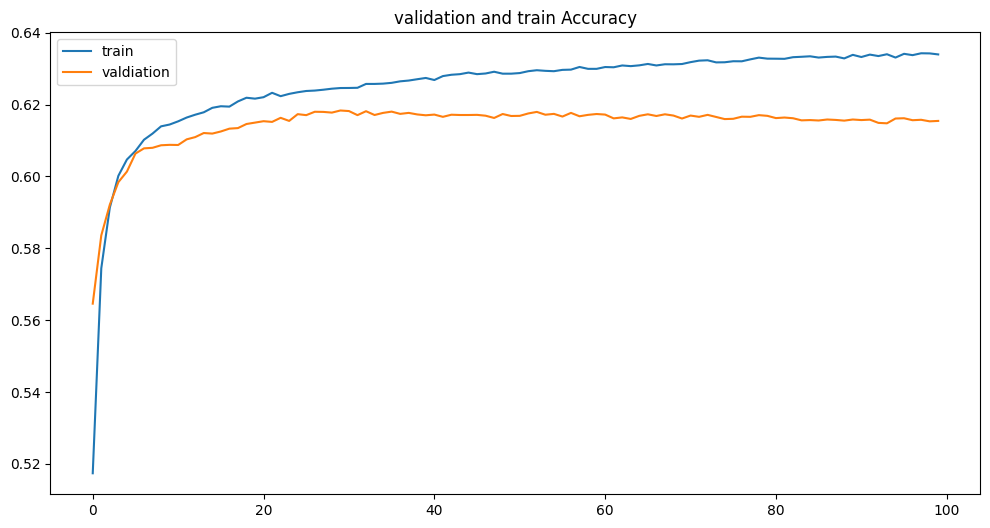

In [194]:
AccuracyPlot(history1)

In [195]:
model2 = Sequential()

model2.add(Dense(units=16, activation='relu', input_dim=X.shape[1]))
model2.add(Dense(units=32, activation='relu'))
model2.add(Dense(units=8, activation='relu'))

# output layer
model2.add(Dense(units=1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.experimental.Adam(learning_rate=0.00001),
              metrics=['accuracy'])
epochs=100
history2 = model2.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=64,
            validation_data= shuffle(X_test, y_test))

Epoch 1/100
931/931 [==============================] - 6s 5ms/step - loss: 0.7192 - accuracy: 0.5096 - val_loss: 0.7062 - val_accuracy: 0.5199
Epoch 2/100
931/931 [==============================] - 4s 5ms/step - loss: 0.7011 - accuracy: 0.5302 - val_loss: 0.6953 - val_accuracy: 0.5356
Epoch 3/100
931/931 [==============================] - 5s 6ms/step - loss: 0.6935 - accuracy: 0.5405 - val_loss: 0.6898 - val_accuracy: 0.5432
Epoch 4/100
931/931 [==============================] - 5s 5ms/step - loss: 0.6890 - accuracy: 0.5486 - val_loss: 0.6861 - val_accuracy: 0.5535
Epoch 5/100
931/931 [==============================] - 5s 6ms/step - loss: 0.6856 - accuracy: 0.5551 - val_loss: 0.6832 - val_accuracy: 0.5599
Epoch 6/100
931/931 [==============================] - 6s 7ms/step - loss: 0.6828 - accuracy: 0.5619 - val_loss: 0.6807 - val_accuracy: 0.5651
Epoch 7/100
931/931 [==============================] - 4s 4ms/step - loss: 0.6804 - accuracy: 0.5679 - val_loss: 0.6786 - val_accuracy: 0.5688

In [196]:
y_hat2 = model2.predict(X_test)
findAccuracy(y_hat2)

798/798 [==============================] - 1s 2ms/step
(25512,)

Confusion Matrix is as follows (class 1 is target class)
           Predicted 0  Predicted 1
Actual 0       5890.0       7865.0
Actual 1       2838.0       8919.0

Accuracy is  58.05 %
Error is  41.95 %
Recall is  75.86 %
Precision is  53.14 %


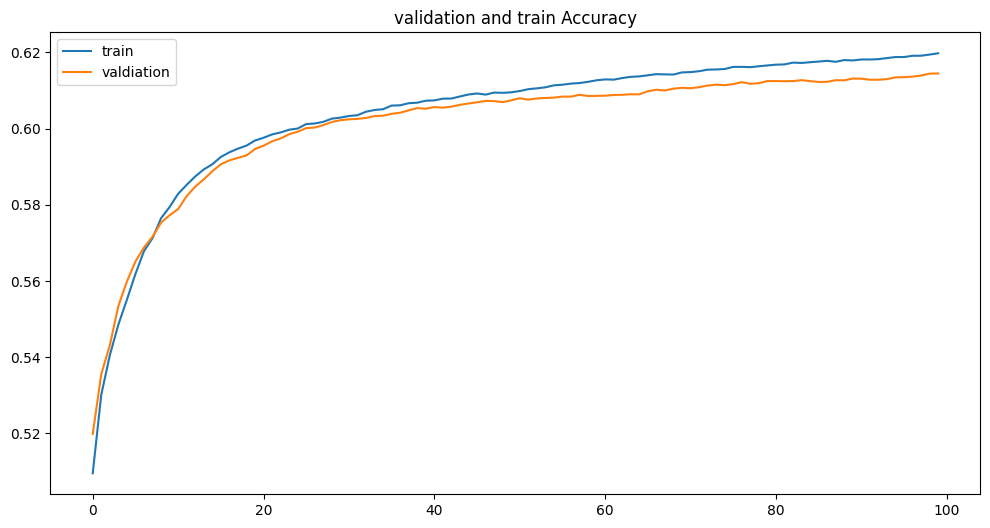

In [198]:
AccuracyPlot(history2)

In [199]:
model3 = Sequential()

model3.add(Dense(units=16, activation='relu', input_dim=X.shape[1]))
model3.add(Dense(units=32, activation='relu'))
model3.add(Dense(units=8, activation='relu'))

# output layer
model3.add(Dense(units=1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.experimental.Adam(learning_rate=0.00001),
              metrics=['accuracy'])
epochs=100
history3 = model3.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=124,
            validation_data= shuffle(X_test, y_test))

Epoch 1/100
481/481 [==============================] - 4s 5ms/step - loss: 0.7222 - accuracy: 0.4600 - val_loss: 0.7163 - val_accuracy: 0.4647
Epoch 2/100
481/481 [==============================] - 2s 5ms/step - loss: 0.7141 - accuracy: 0.4641 - val_loss: 0.7096 - val_accuracy: 0.4737
Epoch 3/100
481/481 [==============================] - 5s 10ms/step - loss: 0.7083 - accuracy: 0.4713 - val_loss: 0.7045 - val_accuracy: 0.4796
Epoch 4/100
481/481 [==============================] - 3s 6ms/step - loss: 0.7038 - accuracy: 0.4819 - val_loss: 0.7006 - val_accuracy: 0.4917
Epoch 5/100
481/481 [==============================] - 2s 5ms/step - loss: 0.7003 - accuracy: 0.4942 - val_loss: 0.6975 - val_accuracy: 0.5062
Epoch 6/100
481/481 [==============================] - 2s 5ms/step - loss: 0.6974 - accuracy: 0.5027 - val_loss: 0.6950 - val_accuracy: 0.5161
Epoch 7/100
481/481 [==============================] - 2s 5ms/step - loss: 0.6950 - accuracy: 0.5119 - val_loss: 0.6929 - val_accuracy: 0.523

In [200]:
y_hat3 = model3.predict(X_test)
findAccuracy(y_hat3)

798/798 [==============================] - 1s 1ms/step
(25512,)

Confusion Matrix is as follows (class 1 is target class)
           Predicted 0  Predicted 1
Actual 0       5591.0       8164.0
Actual 1       2814.0       8943.0

Accuracy is  56.97 %
Error is  43.03 %
Recall is  76.07 %
Precision is  52.28 %


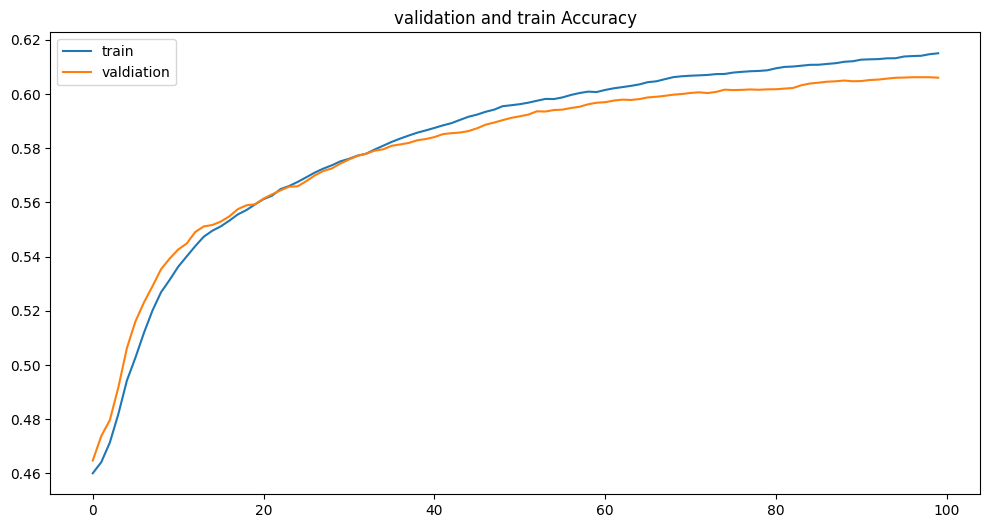

In [202]:
AccuracyPlot(history3)

From the Accuracy and recall scores, for neural nets we decided to use the model 4 with 100 epochs, 2 hidden layers, 128 batch size and 0.00001 learning late. This model has given average accuracy while giving  a average recall of 23%. 

### Conclusion:

Since the distribution of the features were not that much different between the target class and the other, we did not see much accuracy in the models. However, since our dataset is based on patient welfare, we should give more importance to recall while maintaining a decent average. [it is better if we predict a non-returning patient as re-admitted than if we predict a patient who might get re-admitted as wont be re-admitted]. Keeping this in mind, comparing the models, I believe logistic regression is the best fit for the business need. 
However, with more details on the patient history like number of previous re-admission, medicine dosage etc we should be able to do better predictions.